## 0. Setting

In [26]:
# 1. Standard libraries
import gc
import glob
import os
import re
import hashlib

GLOBAL_SEED = 20250922


# 2. Third-party libraries
import geopandas as gpd
import mapclassify
import numpy as np
import pandas as pd
from shapely.geometry import Point
from shapely.ops import nearest_points

# 3. Visualization libraries (Matplotlib)
import matplotlib.image as mimg
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import font_manager as fm
from matplotlib import patheffects as path_effects
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.patches import Patch
from shapely.affinity import translate as shp_translate
import matplotlib.patches as mpatches


if os.getcwd().endswith('notebooks'):
    os.chdir('..')

# 1) Specify font using absolute path (modify filename/path accordingly)
font_regular = os.path.abspath("assets/malgun.ttf")     # Regular
font_bold    = os.path.abspath("assets/malgunbd.ttf")   # Bold

# 3) Register fonts in Matplotlib font manager
fm.fontManager.addfont(font_regular)
fm.fontManager.addfont(font_bold)

# 4) Safely extract the family name from the font file and apply globally
fam = fm.FontProperties(fname=font_regular).get_name()  # Should be 'Malgun Gothic'
plt.rcParams.update({
    "font.family": fam,
    "axes.unicode_minus": False,  # Prevent minus sign from breaking
})

ARROW_FILE    = "assets/north_arrow.png"


## 1. Data Preparation

In [27]:
SGG_map = gpd.read_file('data/processed/map/SGG_map.gpkg')
SGG_map['centroid'] = SGG_map.geometry.centroid

# Get all matching CSV files
all_files = glob.glob("data/processed/deal_network/deal_by/network_by_*.csv")

# Create a dictionary to store DataFrames
nw_dict = {}

for file in all_files:
    # Extract key from file name, e.g., 'network_by_age (man).csv' → 'age (man)'
    key = os.path.basename(file).replace("network_by_", "").replace(".csv", "")
    
    # Read the CSV file
    nw = pd.read_csv(file, dtype={'14_시군구코드_buyer':str, '8_시군구코드_seller':str, '1_기준연도':int})
    nw.columns = ['year', 'source', 'target', '거래관계']
    nw = pd.merge(nw, SGG_map[['SIG_CD', 'centroid']], left_on='source', right_on='SIG_CD', how='left')
    nw = pd.merge(nw, SGG_map[['SIG_CD', 'centroid']], left_on='target', right_on='SIG_CD', how='left', suffixes=('_seller', '_buyer'))
    nw = nw.drop(columns=['SIG_CD_seller', 'SIG_CD_buyer'])
    
    # Store DataFrame in dictionary
    nw_dict[key] = nw
    
desired_order = [
    'all',
    'man',
    'innovation',
    'urban_size_소상공인',
    'urban_size_중소기업',
    'urban_size_중견기업',
    'urban_size_대기업',
    'urban_age_1년 미만',
    'urban_age_1~5년 미만',
    'urban_age_5~10년 미만',
    'urban_age_10년 이상'
]

# 2. 새로운 딕셔너리를 만들어 순서를 적용합니다.
#    (혹시 모를 에러를 방지하기 위해 nw_dict에 실제 있는 키만 가져옵니다.)
ordered_nw_dict = {key: nw_dict[key] for key in desired_order if key in nw_dict}

# 3. 원래 nw_dict를 정렬된 딕셔너리로 교체합니다.
nw_dict = ordered_nw_dict

# ===== 유틸리티 함수 =====
def build_color_table(max_id=600):
    """고유 ID에 대한 색상 테이블 생성 (노드 라벨 색상에 사용)"""
    pal = list(plt.get_cmap("Set1").colors) \
        + list(plt.get_cmap("Dark2").colors) \
        + list(plt.get_cmap("Accent").colors)
    return {cid: mcolors.to_rgba(pal[cid % len(pal)], 1.0) for cid in range(max_id)}

COLOR_OF = build_color_table(600)

## 2. Data table

In [28]:
SIDO_NM_map = {
    '11': '서울특별시', '26': '부산광역시', '27': '대구광역시', '28': '인천광역시',
    '29': '광주광역시', '30': '대전광역시', '31': '울산광역시', '36': '세종특별자치시',
    '41': '경기도', '51': '강원특별자치도', '43': '충청북도', '44': '충청남도',
    '52': '전북특별자치도', '46': '전라남도', '47': '경상북도', '48': '경상남도',
    '50': '제주특별자치도'
}

# ========= Paths / Parameters =========
BASE_DEAL_DIR = "data/processed/deal_network/deal_by"
COMM_BASE_DIR = "outputs/gpkg/communities"
TABLE_DIR     = "outputs/tables/intra_communities_DII_RSI"
os.makedirs(TABLE_DIR, exist_ok=True)

COMMUNITY_METHODS = ['Infomap', "Leiden", "Louvain"]
WEIGHTS           = ["거래관계"]

# ===== Utility functions =====
def compute_dii_rsi_intra_per_community(ed: pd.DataFrame, lab_map: dict, weight_col: str, year: int, method: str):
    """
    커뮤니티 내부 edge만 고려하여 각 커뮤니티 안에서 시군구 단위 DII, RSI 계산
    """
    ed_use = ed.dropna(subset=["source","target",weight_col]).copy()
    ed_use[weight_col] = pd.to_numeric(ed_use[weight_col], errors="coerce").fillna(0)

    # 소속 커뮤니티 매핑
    ed_use["c_s"] = ed_use["source"].map(lab_map)
    ed_use["c_t"] = ed_use["target"].map(lab_map)
    ed_use = ed_use.dropna(subset=["c_s","c_t"])

    results_rsi, results_dii = [], []

    for comm in sorted(set(lab_map.values())):
        sub = ed_use[(ed_use["c_s"] == comm) & (ed_use["c_t"] == comm)].copy()
        if sub.empty:
            continue

        # RSI (edge-level within community)
        total_flow = sub[weight_col].sum()
        if total_flow > 0:
            sub["RSI"] = sub[weight_col] / total_flow * 100
        else:
            sub["RSI"] = 0.0
        rsi_df = sub[["source","target",weight_col,"RSI"]].copy()
        rsi_df["year"] = year
        rsi_df["community"] = comm
        rsi_df["method"] = method
        results_rsi.append(rsi_df)

        # DII (node-level within community)
        inflow = sub.groupby("target")[weight_col].sum()
        outflow = sub.groupby("source")[weight_col].sum()
        io_sum = inflow.add(outflow, fill_value=0)
        mean_io = io_sum.mean() if not io_sum.empty else 1.0
        dii = io_sum / mean_io if mean_io > 0 else io_sum
        dii_df = dii.rename("DII").reset_index().rename(columns={dii.index.name:"SIG_CD"})
        dii_df["year"] = year
        dii_df["community"] = comm
        dii_df["method"] = method
        results_dii.append(dii_df)

    return (
        pd.concat(results_rsi, ignore_index=True) if results_rsi else pd.DataFrame(),
        pd.concat(results_dii, ignore_index=True) if results_dii else pd.DataFrame()
    )

# ===== Main loop =====
for key, ed in nw_dict.items():
    all_rsi, all_dii = [], []

    for weight in WEIGHTS:
        gpkg = os.path.join(COMM_BASE_DIR, key, f"{weight}_SGG_map_zone_community.gpkg")
        if not os.path.exists(gpkg): 
            continue

        g = gpd.read_file(gpkg)
        if "SIGUNGU_CD" not in g.columns:
            print(f"[SKIP] {key}/{weight}: SIGUNGU_CD not found")
            continue
        g["SIGUNGU_CD"] = g["SIGUNGU_CD"].astype(str)

        years = sorted({int(c.split("_")[-1]) for c in g.columns 
                        if c.startswith(tuple(f"{m}_canon_" for m in COMMUNITY_METHODS))})
        if not years: 
            print(f"[SKIP] {key}/{weight}: no canonical years")
            continue

        if not all(c in ed.columns for c in ['year','source','target',weight]):
            print(f"[SKIP] {key}: edges missing required columns")
            continue

        ed_use = ed.dropna(subset=["source","target","year"]).copy()
        ed_use["source"] = ed_use["source"].astype(str)
        ed_use["target"] = ed_use["target"].astype(str)
        ed_use[weight] = pd.to_numeric(ed_use[weight], errors="coerce").fillna(0)

        for method in COMMUNITY_METHODS:
            for y in years:
                col_canon = f"{method}_canon_{y}"
                if col_canon not in g.columns: 
                    continue

                s_year = g[["SIGUNGU_CD", col_canon]].dropna(subset=[col_canon])
                s_year[col_canon] = s_year[col_canon].astype(int)
                lab_map = s_year.set_index("SIGUNGU_CD")[col_canon].to_dict()

                ede = ed_use[ed_use["year"] == y].copy()
                if ede.empty: 
                    continue

                # intra-community RSI/DII
                rsi_df, dii_df = compute_dii_rsi_intra_per_community(ede, lab_map, weight, year=y, method=method)
                if not rsi_df.empty:
                    rsi_df["key"] = key
                    all_rsi.append(rsi_df)
                if not dii_df.empty:
                    dii_df["key"] = key
                    all_dii.append(dii_df)

    # ===== Post-process records =====
    if all_dii:
        dii_records = pd.concat(all_dii, ignore_index=True)

        # Merge with SGG names
        SGG_map_temp = SGG_map[['SIG_CD','SIG_KOR_NM']].copy()
        SGG_map_temp['SIGUNGU_NM'] = SGG_map_temp['SIG_KOR_NM']
        dii_records = pd.merge(dii_records, SGG_map_temp[['SIG_CD','SIGUNGU_NM']], on='SIG_CD', how='left')

        # Merge with SIDO names
        dii_records['SIDO_CD'] = dii_records['SIG_CD'].str[:2].str.zfill(2)
        dii_records['SIDO_NM'] = dii_records['SIDO_CD'].map(SIDO_NM_map)
        dii_records.drop(columns=['SIDO_CD'], inplace=True)

        DII_OUT = os.path.join(TABLE_DIR, f"dii_{key}.csv")
        dii_records.to_csv(DII_OUT, index=False, encoding="cp949")
        print(f"[OK] DII saved to {DII_OUT}")
    else:
        print(f"[WARN] No DII results for {key}")

    if all_rsi:
        rsi_records = pd.concat(all_rsi, ignore_index=True)

        # Merge with SGG names
        SGG_map_temp = SGG_map[['SIG_CD','SIG_KOR_NM']].copy()
        SGG_map_temp['source'] = SGG_map_temp['SIG_CD'].astype(str)
        SGG_map_temp['target'] = SGG_map_temp['SIG_CD'].astype(str)
        SGG_map_temp['SIGUNGU_NM_source'] = SGG_map_temp['SIG_KOR_NM']
        SGG_map_temp['SIGUNGU_NM_target'] = SGG_map_temp['SIG_KOR_NM']

        rsi_records = pd.merge(rsi_records, SGG_map_temp[['source','SIGUNGU_NM_source']], on='source', how='left')
        rsi_records = pd.merge(rsi_records, SGG_map_temp[['target','SIGUNGU_NM_target']], on='target', how='left')

        # Merge with SIDO names
        rsi_records['SIDO_source'] = rsi_records['source'].str[:2].str.zfill(2)
        rsi_records['SIDO_target'] = rsi_records['target'].str[:2].str.zfill(2)
        rsi_records['SIDO_NM_source'] = rsi_records['SIDO_source'].map(SIDO_NM_map)
        rsi_records['SIDO_NM_target'] = rsi_records['SIDO_target'].map(SIDO_NM_map)
        rsi_records.drop(columns=['SIDO_source','SIDO_target'], inplace=True)

        RSI_OUT = os.path.join(TABLE_DIR, f"rsi_{key}.csv")
        rsi_records.to_csv(RSI_OUT, index=False, encoding="cp949")
        print(f"[OK] RSI saved to {RSI_OUT}")
    else:
        print(f"[WARN] No RSI results for {key}")


[OK] DII saved to outputs/tables/intra_communities_DII_RSI/dii_all.csv
[OK] RSI saved to outputs/tables/intra_communities_DII_RSI/rsi_all.csv
[OK] DII saved to outputs/tables/intra_communities_DII_RSI/dii_man.csv
[OK] RSI saved to outputs/tables/intra_communities_DII_RSI/rsi_man.csv
[OK] DII saved to outputs/tables/intra_communities_DII_RSI/dii_innovation.csv
[OK] RSI saved to outputs/tables/intra_communities_DII_RSI/rsi_innovation.csv
[OK] DII saved to outputs/tables/intra_communities_DII_RSI/dii_urban_size_소상공인.csv
[OK] RSI saved to outputs/tables/intra_communities_DII_RSI/rsi_urban_size_소상공인.csv
[OK] DII saved to outputs/tables/intra_communities_DII_RSI/dii_urban_size_중소기업.csv
[OK] RSI saved to outputs/tables/intra_communities_DII_RSI/rsi_urban_size_중소기업.csv
[OK] DII saved to outputs/tables/intra_communities_DII_RSI/dii_urban_size_중견기업.csv
[OK] RSI saved to outputs/tables/intra_communities_DII_RSI/rsi_urban_size_중견기업.csv
[OK] DII saved to outputs/tables/intra_communities_DII_RSI/dii

# 3. Intra commuity geovisualization

In [ ]:
# -*- coding: utf-8 -*-
"""
Internal community-flow plotter with island insets (Jeju / Ulleung)
- If Jeju (50110, 50130) or Ulleung (47940) are > 50 km from other nodes,
  move them near the mainland edge (no polygon overlap), draw a dashed box,
  and set axes limits based on node (centroid) extent, not polygon extent.

Assumptions
- CRS: EPSG:5179 (meters)
- `nw_dict` is a dict-like: {key: DataFrame of edges}, already loaded by user
- Community GPKGs exist at: outputs/gpkg/communities/{key}/{weight}_SGG_map_zone_community.gpkg
- Edge columns (renamed below if needed): 'source', 'target', 'year', and weight (e.g., '거래관계')
"""

# ========= 경로/파라미터 =========
BASE_DEAL_DIR = "data/processed/deal_network/deal_by"
COMM_BASE_DIR = "outputs/gpkg/communities"
SGG_MAP_PATH  = "data/processed/map/SGG_map.gpkg"
SIDO_PATH     = "data/raw/bnd_sido_00_2024_2Q/bnd_sido_00_2024_2Q.shp"
OUT_DIR_ORIGINAL = "outputs/figures/communities/intra_flows_original"
OUT_DIR_BACKBONE = "outputs/figures/communities/intra_flows_backbone"
ARROW_FILE    = "north_arrow.png"

COMMUNITY_METHODS = ['Infomap', 'Leiden', 'Louvain']
WEIGHTS           = ["거래관계"]
ALPHA_LEVEL       = 0.1

# --- [MODIFIED] Original Link/Node 스타일 ---
BASE_LW, LW_RANGE, RSI_W_BLEND = 0.5, 4.5, 0.30
MIN_ALPHA, MAX_ALPHA, N_SEG = 0.1, 0.99, 30
DII_BASE, DII_RANGE, DII_CLIP_HI = 10, 80, 4.0
FONT_SIZE_MIN, FONT_SIZE_MAX = 4.0, 6.0

# --- [MODIFIED] Backbone Link/Node 스타일 ---
BASE_LW_bb, LW_RANGE_bb, RSI_W_BLEND_bb = 1, 6, 0.30
MIN_ALPHA_bb, MAX_ALPHA_bb = 0.1, 0.99

# --- RSI 범례 ---
RSI_CLIP_HI_QUANT = 0.999
RSI_PCT_LABELS    = [0.90, 0.95, 0.99, 0.999]
CURVATURE = 0.22

# ========= 유틸리티 함수 =========
JEJU_CODES     = {"50110","50130"}  # 제주시, 서귀포시
ULLEUNG_CODES  = {"47940"}           # 울릉군


def extract_disparity_backbone(df: pd.DataFrame, source_col:str, target_col:str, weight_col: str, alpha: float = 0.05) -> pd.DataFrame:
    """Serrano et al. (2009) disparity filter backbone (outgoing). Returns subset of df."""
    edges = df[[source_col, target_col, weight_col]].copy()
    edges.rename(columns={source_col: 'source', target_col: 'target', weight_col: 'weight'}, inplace=True)
    node_stats = edges.groupby('source')['weight'].agg(['sum', 'count']).rename(columns={'sum': 's_out', 'count': 'k_out'})
    edges = edges.merge(node_stats, left_on='source', right_index=True)
    edges['p_ij'] = (edges['weight'] / edges['s_out']).fillna(0)
    k_minus_1 = edges['k_out'] - 1
    alpha_ij = np.power(1.0 - edges['p_ij'], k_minus_1.clip(lower=0))
    alpha_ij[edges['k_out'] <= 1] = 0.0
    backbone_edges = edges[alpha_ij < alpha]
    return df.merge(
        backbone_edges[['source', 'target']].rename(columns={'source': source_col, 'target': target_col}),
        on=[source_col, target_col], how='inner'
    )


def _norm01(a):
    a = np.asarray(a, float)
    if a.size == 0:
        return a
    vmin, vmax = np.nanmin(a), np.nanmax(a)
    if not (np.isfinite(vmin) and np.isfinite(vmax) and vmax > vmin):
        return np.full_like(a, 0.5)
    return (a - vmin) / (vmax - vmin)


def _curve_segments(p1, p2, curvature=CURVATURE, nseg=N_SEG):
    mx, my = (p1.x + p2.x)/2, (p1.y + p2.y)/2
    dx, dy = p2.x - p1.x, p2.y - p1.y
    dist = np.hypot(dx, dy)
    if dist == 0:
        return None, None
    px, py = -dy/dist, dx/dist
    cx, cy = mx + px * dist * curvature, my + py * dist * curvature
    t = np.linspace(0, 1, nseg + 1)
    bx = (1-t)**2*p1.x + 2*(1-t)*t*cx + t**2*p2.x
    by = (1-t)**2*p1.y + 2*(1-t)*t*cy + t**2*p2.y
    segs = np.stack([np.column_stack([bx[:-1], by[:-1]]), np.column_stack([bx[1:], by[1:]])], axis=1)
    cols = np.linspace((1., 0., 0., 1.), (1., 1., 0., 1.), nseg)  # red -> yellow RGBA
    return segs, cols


def add_north_arrow(ax, x, y, arrow_file, zoom=0.18):
    try:
        import matplotlib.image as mimg
        from matplotlib.offsetbox import AnnotationBbox, OffsetImage
        if os.path.exists(arrow_file):
            im = mimg.imread(arrow_file)
            ab = AnnotationBbox(OffsetImage(im, zoom=zoom), (x, y), xycoords='axes fraction', frameon=False)
            ax.add_artist(ab)
    except Exception as e:
        print(f"Could not add north arrow: {e}")


def add_scale_bar(ax, location=(0.06,0.03), linewidth=3, color='black'):
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    map_width = xlim[1] - xlim[0]
    candidates = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
    length = max([c for c in candidates if c <= map_width / 4], default=min(candidates))
    sb_x = xlim[0] + (xlim[1] - xlim[0]) * location[0]
    sb_y = ylim[0] + (ylim[1] - ylim[0]) * location[1]
    ax.plot([sb_x, sb_x + length], [sb_y, sb_y], color=color, linewidth=linewidth)
    ax.text(sb_x + length / 2, sb_y, f'{round(length/1000):,} km', va='bottom', ha='center', fontsize=9)


def apply_island_insets(SGG: gpd.GeoDataFrame,
                        SGG_pts: pd.Series,
                        members: list,
                        threshold_km: float = 50.0,
                        side_for_group: dict = None):
    """
    If Jeju / Ulleung centroids are farther than threshold_km from mainland nodes,
    move each island group to an inset location near the mainland bounding box edge.

    IMPORTANT: When moving, only move the polygon *that contains the node (centroid)*
    for each SIG_CD in the island group. Small detached islets (e.g., Dokdo) are
    not moved (and effectively dropped from the inset view), so the inset shows
    just the main landmass per node.

    Returns: (moved_polygons_gdf, moved_points_series, list_of_rectangle_patches)
    """
    from shapely.ops import unary_union

    threshold_m = threshold_km * 1000.0
    side_for_group = side_for_group or {
        "JEJU": "bottom",     # left/right/top/bottom
        "ULLEUNG": "right",
    }

    mem_set = set(map(str, members))
    g_comm  = SGG[SGG["SIG_CD"].isin(mem_set)].copy()
    pts_all = SGG_pts.copy()

    groups = [("JEJU", JEJU_CODES & mem_set), ("ULLEUNG", ULLEUNG_CODES & mem_set)]
    groups = [(name, codes) for name, codes in groups if len(codes) > 0]

    island_all_codes = set().union(*[codes for _, codes in groups]) if groups else set()
    mainland_codes   = list(mem_set - island_all_codes)
    if len(mainland_codes) == 0:
        return g_comm, pts_all, []  # nothing to do if no mainland

    # Mainland bbox for where to dock insets
    g_main = g_comm[g_comm["SIG_CD"].isin(mainland_codes)]
    minx, miny, maxx, maxy = g_main.total_bounds
    main_w, main_h = (maxx - minx), (maxy - miny)
    max_range = max(main_w, main_h)
    gap = max(50000.0, 0.01 * max_range)  # >= 50 km or 1%

    main_pts = pts_all[pts_all.index.isin(mainland_codes)]
    inset_boxes = []

    # Helper: pick the polygon part that contains (or is closest to) the centroid
    def _pick_main_part(geom, pt):
        try:
            parts = list(geom.geoms) if hasattr(geom, "geoms") else [geom]
        except Exception:
            parts = [geom]
        # Prefer any part that covers the centroid
        covers = [p for p in parts if p.buffer(0).covers(pt)]
        if covers:
            # If multiple cover (rare), choose the largest area
            return max(covers, key=lambda p: p.area)
        # Fallback: choose the nearest polygon to the centroid
        return min(parts, key=lambda p: p.distance(pt))

    for name, codes in groups:
        isl_pts = pts_all[pts_all.index.isin(codes)]
        if isl_pts.empty or main_pts.empty:
            continue

        # Measure distance from island group center to any mainland node
        cx, cy = isl_pts.x.mean(), isl_pts.y.mean()
        dmin = float("inf")
        for _, p in main_pts.items():
            d = ((p.x - cx)**2 + (p.y - cy)**2)**0.5
            if d < dmin:
                dmin = d
        if dmin <= threshold_m:
            continue  # close enough → no inset move

        # Build a geometry set made ONLY of the polygon that contains each node (centroid)
        selected_polys = []
        for c in codes:
            row = g_comm[g_comm["SIG_CD"] == c]
            if row.empty:
                continue
            geom = row.iloc[0].geometry
            pt   = pts_all.loc[c]
            main_part = _pick_main_part(geom, pt)
            # Replace geometry for this code with only the main part (drop tiny islets like Dokdo)
            g_comm.loc[g_comm["SIG_CD"] == c, "geometry"] = main_part
            selected_polys.append(main_part)

        if not selected_polys:
            continue

        grp_union = unary_union(selected_polys)
        gx0, gy0, gx1, gy1 = grp_union.bounds
        gw, gh = (gx1 - gx0), (gy1 - gy0)

        side = side_for_group.get(name, "left")
        if side == "left":
            target_minx = minx - gap - gw
            target_miny = miny + gap
        elif side == "right":
            target_minx = maxx + gap
            target_miny = miny + gap*3
        elif side == "top":
            target_minx = minx + gap
            target_miny = maxy + gap
        else:  # bottom
            target_minx = minx + gap*2
            target_miny = miny - gap - gh

        dx, dy = target_minx - gx0, target_miny - gy0

        # Translate ONLY the selected island codes (their geometries are already reduced to main parts)
        mask_grp = g_comm["SIG_CD"].isin(codes)
        g_comm.loc[mask_grp, "geometry"] = g_comm.loc[mask_grp, "geometry"].apply(lambda geom: shp_translate(geom, xoff=dx, yoff=dy))
        for c in codes:
            pts_all.loc[c] = shp_translate(pts_all.loc[c], xoff=dx, yoff=dy)

        # Build an inset rectangle around the moved main parts
        moved_union = shp_translate(grp_union, xoff=dx, yoff=dy)
        x0, y0, x1, y1 = moved_union.bounds
        pad = max(5000.0, 0.01 * max_range)
        rect = mpatches.Rectangle((x0 - pad, y0 - pad), (x1 - x0) + 2*pad, (y1 - y0) + 2*pad,
                                  fill=False, linewidth=1.2, linestyle="--", edgecolor="black", zorder=5)
        inset_boxes.append(rect)

    return g_comm, pts_all, inset_boxes


def module_color(cid: int):
    # deterministic color by module id using tab20
    cmap = plt.get_cmap('tab20')
    rgba = cmap(cid % 20)
    return mcolors.to_hex(rgba)

# ========= 데이터 준비 =========
SGG = gpd.read_file(SGG_MAP_PATH).to_crs(epsg=5179)
if "SIG_KOR_NM" not in SGG.columns and "SIG_ENG_NM" in SGG.columns:
    SGG["SIG_KOR_NM"] = SGG["SIG_ENG_NM"]
SGG["centroid"] = SGG.geometry.centroid
SGG_pts = SGG.set_index("SIG_CD")["centroid"]
SGG_names = SGG.set_index("SIG_CD")["SIG_KOR_NM"] if "SIG_KOR_NM" in SGG.columns else pd.Series(dtype=str)

os.makedirs(OUT_DIR_ORIGINAL, exist_ok=True)
os.makedirs(OUT_DIR_BACKBONE, exist_ok=True)

# ========= 메인 루프 =========
# Expect: nw_dict is already defined by the user environment
try:
    nw_dict
except NameError:
    raise RuntimeError("`nw_dict` is not defined. Load your per-key edge DataFrames into `nw_dict` before running.")

for key, ed in nw_dict.items():
    # normalize column names
    ed = ed.copy()
    ed.rename(columns={'1_기준연도': 'year', '8_시군구코드_seller': 'source', '14_시군구코드_buyer': 'target'}, inplace=True, errors='ignore')

    for weight in WEIGHTS:
        gpkg = os.path.join(COMM_BASE_DIR, key, f"{weight}_SGG_map_zone_community.gpkg")
        if not os.path.exists(gpkg):
            print(f"[WARN] Missing community file: {gpkg}")
            continue

        g = gpd.read_file(gpkg).to_crs(epsg=5179)
        g["SIGUNGU_CD"] = g["SIGUNGU_CD"].astype(str)

        # find available years from community columns
        cand_prefixes = tuple(f"{m}_canon_" for m in COMMUNITY_METHODS)
        years = sorted({int(c.split("_")[-1]) for c in g.columns if c.startswith(cand_prefixes)})

        if not all(c in ed.columns for c in ['source', 'target', 'year', weight]) or not years:
            print(f"[WARN] Columns or years missing for key={key}")
            continue

        ed_use = ed.dropna(subset=["source", "target", "year"]).copy()
        ed_use["source"] = ed_use["source"].astype(str)
        ed_use["target"] = ed_use["target"].astype(str)
        ed_use[weight] = pd.to_numeric(ed_use[weight], errors="coerce").fillna(0)

        for method in COMMUNITY_METHODS:
            for y in years:
                col_canon = f"{method}_canon_{y}"
                if col_canon not in g.columns:
                    continue

                s_year = g[["SIGUNGU_CD", col_canon]].copy()
                s_year[col_canon] = s_year[col_canon].astype("Int64")
                lab_map = s_year.dropna(subset=[col_canon]).set_index("SIGUNGU_CD")[col_canon].astype(int).to_dict()

                E = ed_use[ed_use["year"] == y].copy()
                if E.empty:
                    continue

                E["m_s"] = E["source"].map(lab_map)
                E["m_t"] = E["target"].map(lab_map)
                E_in = E[(E["m_s"] == E["m_t"]) & E["m_s"].notna()].copy()
                if E_in.empty:
                    continue

                E_in["m_s"] = E_in["m_s"].astype(int)
                module_ids = sorted(E_in["m_s"].unique().tolist())

                for cid in module_ids:
                    F_all = E_in[E_in["m_s"] == cid].copy()
                    if F_all.empty:
                        continue

                    members = s_year[s_year[col_canon] == cid]["SIGUNGU_CD"].astype(str).tolist()
                    if len(members) < 2:
                        continue

                    # --- 1) Compute DII and RSI on internal flows (excluding self-loops) ---
                    io_sum = {}
                    for _, r in F_all[F_all['source'] != F_all['target']].iterrows():
                        s, t, w_val = r['source'], r['target'], r[weight]
                        io_sum[s] = io_sum.get(s, 0.0) + w_val
                        io_sum[t] = io_sum.get(t, 0.0) + w_val
                    mean_io = np.mean(list(io_sum.values())) if io_sum else 0
                    dii_local = {sgg: (io_sum.get(sgg, 0) / mean_io) if mean_io > 0 else 1.0 for sgg in members}
                    node_sizes = {s: DII_BASE + DII_RANGE * dii_local.get(s, 1.0) for s in members}

                    total_flow = F_all[F_all['source'] != F_all['target']][weight].sum()
                    F_all['__RSI__'] = (F_all[weight] / total_flow) if total_flow > 0 else 0

                    rsi_vals_all = F_all['__RSI__'].values
                    clip_hi = np.quantile(rsi_vals_all, RSI_CLIP_HI_QUANT) if rsi_vals_all.size > 0 else 0.01
                    if clip_hi <= 0:
                        clip_hi = 0.01

                    rsi_scaled_01 = np.clip(F_all['__RSI__'] / clip_hi, 0, 1).values
                    F_all['rsi_scaled_01'] = rsi_scaled_01

                    vmax = F_all[weight].max()
                    logv = np.log10((F_all[weight] / vmax) * 9.0 + 1.0) if vmax > 0 else 0
                    F_all['w_norm'] = _norm01(logv if np.isscalar(logv) else logv.values)

                    # --- 2) Backbone ---
                    F_backbone = extract_disparity_backbone(
                        F_all[F_all['source'] != F_all['target']], 'source', 'target', weight, alpha=ALPHA_LEVEL
                    )

                    # --- 3) Plot tasks ---
                    plot_tasks = [
                        {'name': 'Original', 'df': F_all, 'dir': OUT_DIR_ORIGINAL, 'prefix': ''},
                        {'name': 'Backbone', 'df': F_backbone, 'dir': OUT_DIR_BACKBONE, 'prefix': f'[Backbone ({len(F_backbone)/len(F_all)*100:.1f}%)] '}
                    ]

                    for task in plot_tasks:
                        task_name, df_plot, out_dir_base, title_prefix = task['name'], task['df'], task['dir'], task['prefix']
                        outdir = os.path.join(out_dir_base, key, weight)
                        os.makedirs(outdir, exist_ok=True)
                        out_png = os.path.join(outdir, f"{method}_{y}_M{cid}_internal_{task_name.lower()}.png")

                        if os.path.exists(out_png):
                            print(f"[SKIP] {out_png}")
                            continue

                        df_plot = df_plot.copy()

                        # --- Style per task ---
                        if task_name == 'Backbone':
                            df_plot['alpha'] = MIN_ALPHA_bb + (MAX_ALPHA_bb - MIN_ALPHA_bb) * df_plot['rsi_scaled_01']
                            df_plot['width'] = BASE_LW_bb + LW_RANGE_bb * ((1.0 - RSI_W_BLEND_bb) * df_plot['w_norm'] + RSI_W_BLEND_bb * df_plot['rsi_scaled_01'])
                        else:  # Original
                            df_plot['alpha'] = MIN_ALPHA + (MAX_ALPHA - MIN_ALPHA) * df_plot['rsi_scaled_01']
                            df_plot['width'] = BASE_LW + LW_RANGE * ((1.0 - RSI_W_BLEND) * df_plot['w_norm'] + RSI_W_BLEND * df_plot['rsi_scaled_01'])

                        fig, ax = plt.subplots(figsize=(10, 11), dpi=100)
                        ax.set_position([0.15, 0.12, 0.7, 0.7])
                        ax.set_aspect("equal")
                        ax.set_axis_off()

                        # --- (NEW) 섬 인셋 처리 ---
                        COMMUNITY_SGG_plot, SGG_pts_plot, inset_boxes = apply_island_insets(
                            SGG=SGG,
                            SGG_pts=SGG_pts,
                            members=members,
                            threshold_km=50.0,
                            side_for_group={"JEJU":"bottom", "ULLEUNG":"right"}
                        )

                        COMMUNITY_SGG_plot = COMMUNITY_SGG_plot[COMMUNITY_SGG_plot["SIG_CD"].isin(members)]
                        COMMUNITY_SGG_plot.plot(ax=ax, color="#f0f0f0", edgecolor="gray", linewidth=0.5, zorder=1)

                        # --- Axis by NODE extent (not polygon) ---
                        member_pts_plot = SGG_pts_plot[SGG_pts_plot.index.isin(members)]
                        minx_nodes = float(member_pts_plot.x.min()); maxx_nodes = float(member_pts_plot.x.max())
                        miny_nodes = float(member_pts_plot.y.min()); maxy_nodes = float(member_pts_plot.y.max())
                        dx = maxx_nodes - minx_nodes; dy = maxy_nodes - miny_nodes
                        max_range = max(dx, dy)
                        pad = max(0.1 * max_range, 20000.0)
                        center_x = (minx_nodes + maxx_nodes) / 2.0
                        center_y = (miny_nodes + maxy_nodes) / 2.0
                        ax.set_xlim(center_x - max_range/2 - pad, center_x + max_range/2 + pad)
                        ax.set_ylim(center_y - max_range/2 - pad, center_y + max_range/2 + pad*1.5)

                        for rect in inset_boxes:
                            ax.add_patch(rect)

                        # --- Links (use moved centroids) ---
                        all_segments, all_colors, all_widths = [], [], []
                        for _, row in df_plot.iterrows():
                            s, t = row['source'], row['target']
                            if (s not in SGG_pts_plot.index) or (t not in SGG_pts_plot.index):
                                continue
                            p1, p2 = SGG_pts_plot.loc[s], SGG_pts_plot.loc[t]
                            segs, cols = _curve_segments(p1, p2, curvature=(CURVATURE if s < t else -CURVATURE))
                            if segs is None:
                                continue
                            cols[:, 3] = row['alpha']
                            all_segments.extend(segs)
                            all_colors.extend(cols)
                            all_widths.extend([row['width']] * len(segs))

                        if all_segments:
                            lc = LineCollection(all_segments, colors=all_colors, linewidths=all_widths, capstyle="round", zorder=3)
                            ax.add_collection(lc)

                        # --- Nodes (moved coordinates) ---
                        node_color = module_color(cid)
                        ax.scatter(member_pts_plot.x, member_pts_plot.y,
                                   s=[node_sizes.get(idx, DII_BASE) for idx in member_pts_plot.index],
                                   c=[node_color], alpha=0.5, edgecolors="black", linewidth=0.9, zorder=4)

                        # # Optional labels (disabled by default)
                        # label_offset = (max_range) * 0.01
                        # for sgg_code, pt in member_pts_plot.items():
                        #     sgg_name = SGG_names.get(sgg_code, '') if not SGG_names.empty else ''
                        #     clipped_dii = np.clip(dii_local.get(sgg_code, 1.0), 0, DII_CLIP_HI)
                        #     normalized_dii = clipped_dii / DII_CLIP_HI if DII_CLIP_HI > 0 else 0.5
                        #     fs = FONT_SIZE_MIN + normalized_dii * (FONT_SIZE_MAX - FONT_SIZE_MIN)
                        #     txt = ax.text(pt.x + label_offset, pt.y + label_offset, sgg_name,
                        #                   fontsize=fs, color='black', ha='left', va='bottom', zorder=5)
                        #     txt.set_path_effects([path_effects.Stroke(linewidth=1.2, foreground='white', alpha=0.8),
                        #                           path_effects.Normal()])

                        add_north_arrow(ax, 0.9, 0.95, ARROW_FILE)
                        add_scale_bar(ax)
                        fig.suptitle(f"{title_prefix}Internal Flows: Module M{cid}\n[{key} / {method} / {y}]", fontsize=14, y=0.85)

                        # --- Legend ---
                        handles = []
                        handles.append(Line2D([0],[0], color="none", label="Local DII"))
                        for lab in [0.5, 1.0, 2.0, DII_CLIP_HI]:
                            size_demo = DII_BASE + DII_RANGE * np.clip(lab, 0, DII_CLIP_HI)
                            handles.append(Line2D([], [], marker="o", ls="None", markersize=np.sqrt(size_demo),
                                                  markerfacecolor=node_color, alpha=0.8,
                                                  markeredgecolor="white", mew=0.9, label=f"  ×{lab:g}"))

                        handles.extend([Line2D([0],[0], c="none", label=" "), Line2D([0],[0], c="none", label="RSI (percentile)")])

                        if rsi_vals_all.size > 0:
                            rsi_percentile_values = np.quantile(rsi_vals_all, RSI_PCT_LABELS)
                        else:
                            rsi_percentile_values = np.zeros(len(RSI_PCT_LABELS))
                        rsi_demo_clipped = np.clip(rsi_percentile_values, 0, clip_hi)
                        rsi_demo_scaled_01 = (rsi_demo_clipped / clip_hi) if clip_hi > 0 else np.zeros_like(rsi_demo_clipped)

                        if task_name == 'Backbone':
                            demo_alphas = MIN_ALPHA_bb + (MAX_ALPHA_bb - MIN_ALPHA_bb) * rsi_demo_scaled_01
                        else:
                            demo_alphas = MIN_ALPHA + (MAX_ALPHA - MIN_ALPHA) * rsi_demo_scaled_01

                        for i, pctl in enumerate(RSI_PCT_LABELS):
                            rv = rsi_percentile_values[i]
                            alpha_val = demo_alphas[i]
                            if task_name == 'Backbone':
                                width_demo = BASE_LW_bb + LW_RANGE_bb * ((1.0 - RSI_W_BLEND_bb) * 0.5 + RSI_W_BLEND_bb * rsi_demo_scaled_01[i])
                            else:
                                width_demo = BASE_LW + LW_RANGE * ((1.0 - RSI_W_BLEND) * 0.5 + RSI_W_BLEND * rsi_demo_scaled_01[i])
                            handles.append(Line2D([0],[0], color=(*mcolors.to_rgb("red"), alpha_val), lw=width_demo, solid_capstyle="round",
                                                  label=f"  {rv*100:.2f}% (P{int(pctl*100)})"))

                        handles.extend([Line2D([0],[0], c="none", label=" "), Line2D([0],[0], c="none", label="Direction"),
                                        Line2D([0],[0], c="red", lw=3, label="  Source"), Line2D([0],[0], c="yellow", lw=3, label="  Target")])

                        leg = fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.95, 0.5),
                                         frameon=True, fontsize=8, title="Legend", title_fontsize=12)
                        leg.get_frame().set_alpha(0.96)

                        plt.savefig(out_png, dpi=100, bbox_inches="tight")
                        #plt.show()
                        plt.close(fig)
                        gc.collect()
                        print(f"[OK] Saved {task_name} plot to {out_png}")


[OK] Saved Original plot to outputs/figures/communities/intra_flows_original/all/거래관계/Infomap_2016_M0_internal_original.png
[OK] Saved Backbone plot to outputs/figures/communities/intra_flows_backbone/all/거래관계/Infomap_2016_M0_internal_backbone.png
[OK] Saved Original plot to outputs/figures/communities/intra_flows_original/all/거래관계/Infomap_2016_M1_internal_original.png
[OK] Saved Backbone plot to outputs/figures/communities/intra_flows_backbone/all/거래관계/Infomap_2016_M1_internal_backbone.png
[OK] Saved Original plot to outputs/figures/communities/intra_flows_original/all/거래관계/Infomap_2016_M2_internal_original.png
[OK] Saved Backbone plot to outputs/figures/communities/intra_flows_backbone/all/거래관계/Infomap_2016_M2_internal_backbone.png
[OK] Saved Original plot to outputs/figures/communities/intra_flows_original/all/거래관계/Infomap_2016_M3_internal_original.png
[OK] Saved Backbone plot to outputs/figures/communities/intra_flows_backbone/all/거래관계/Infomap_2016_M3_internal_backbone.png
[OK] Sav

# 4. Inter hirarchy

--- Processing [all / 거래관계 / Infomap] ---


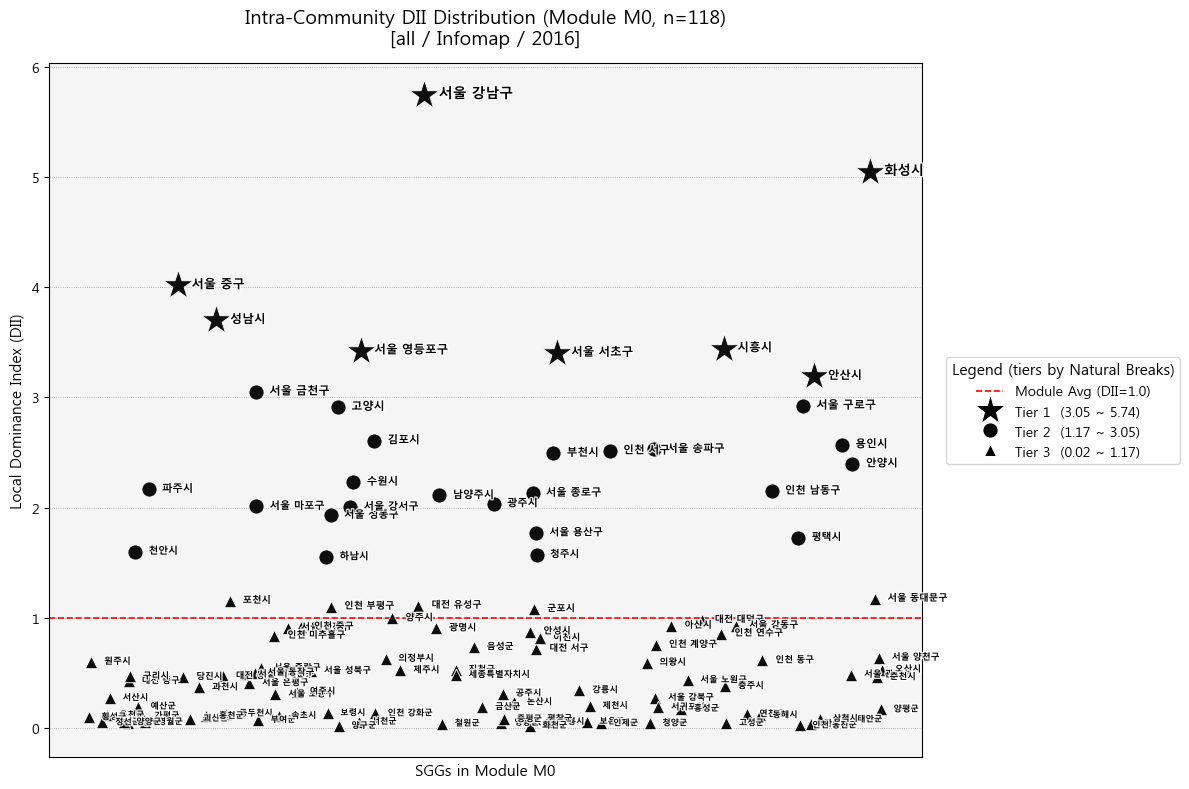

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M0_2016.png


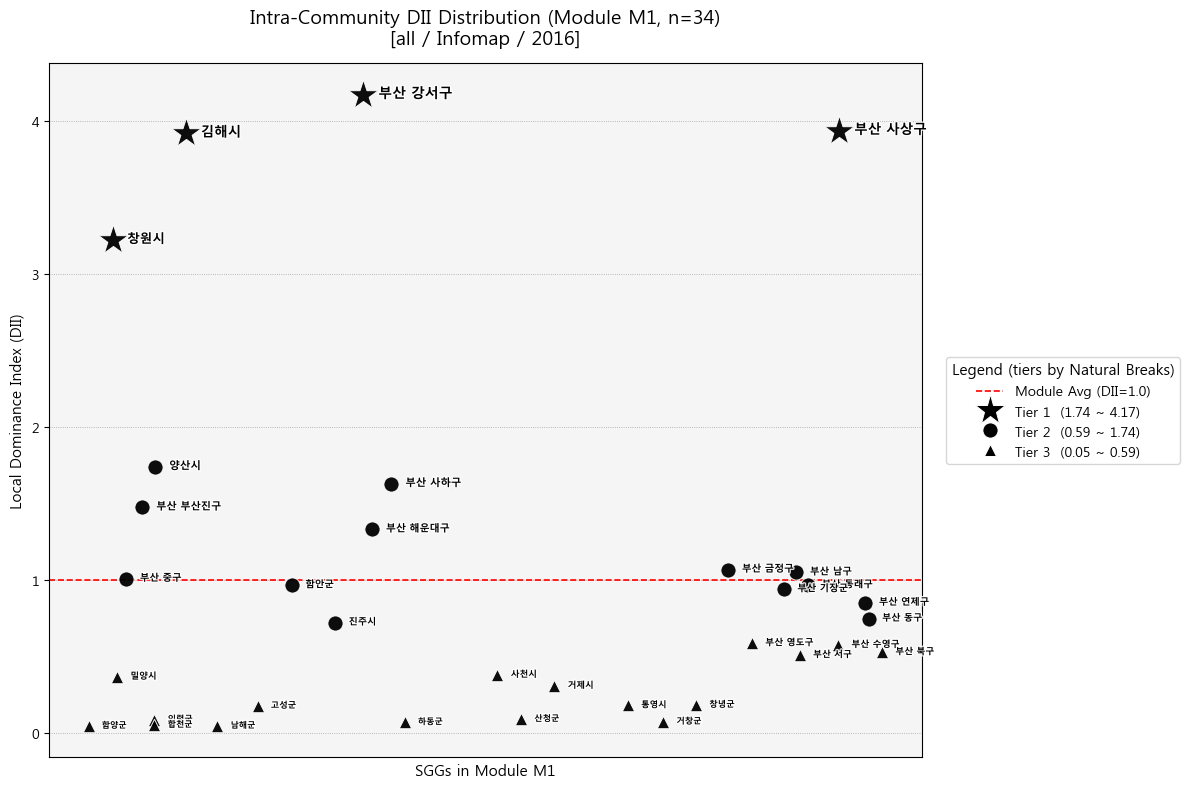

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M1_2016.png


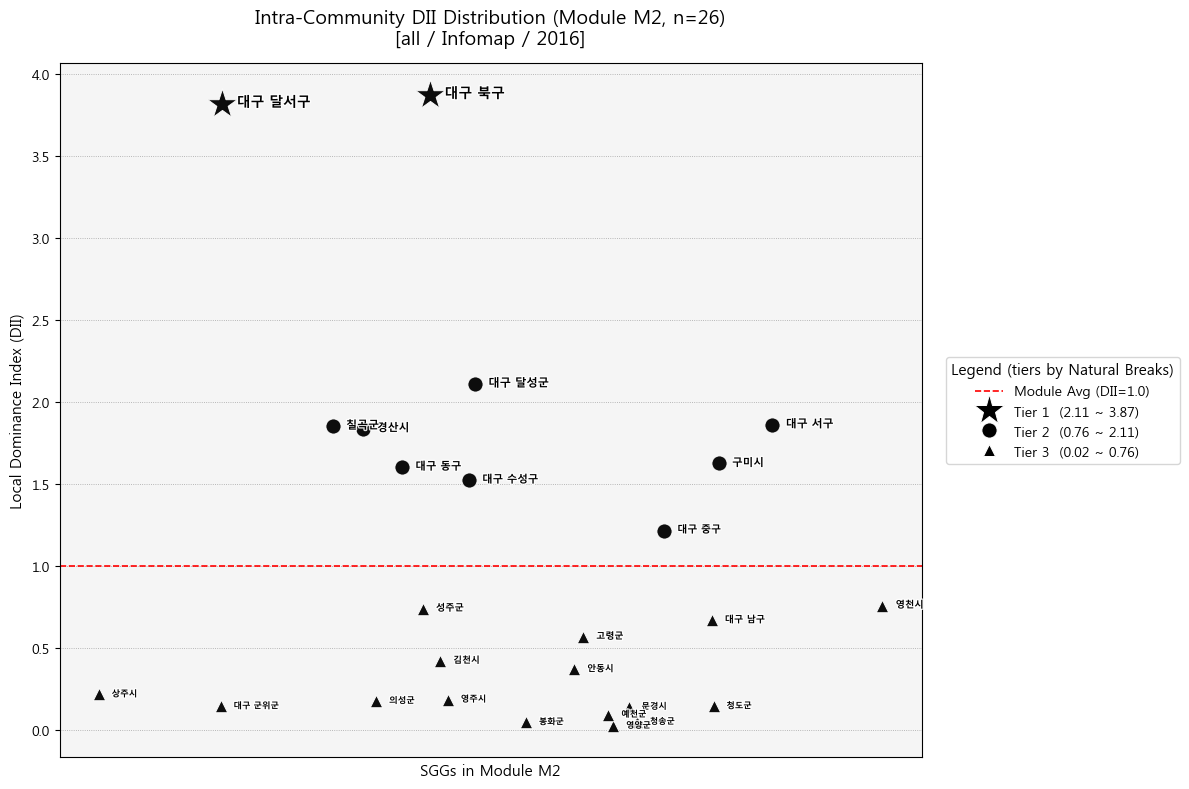

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M2_2016.png


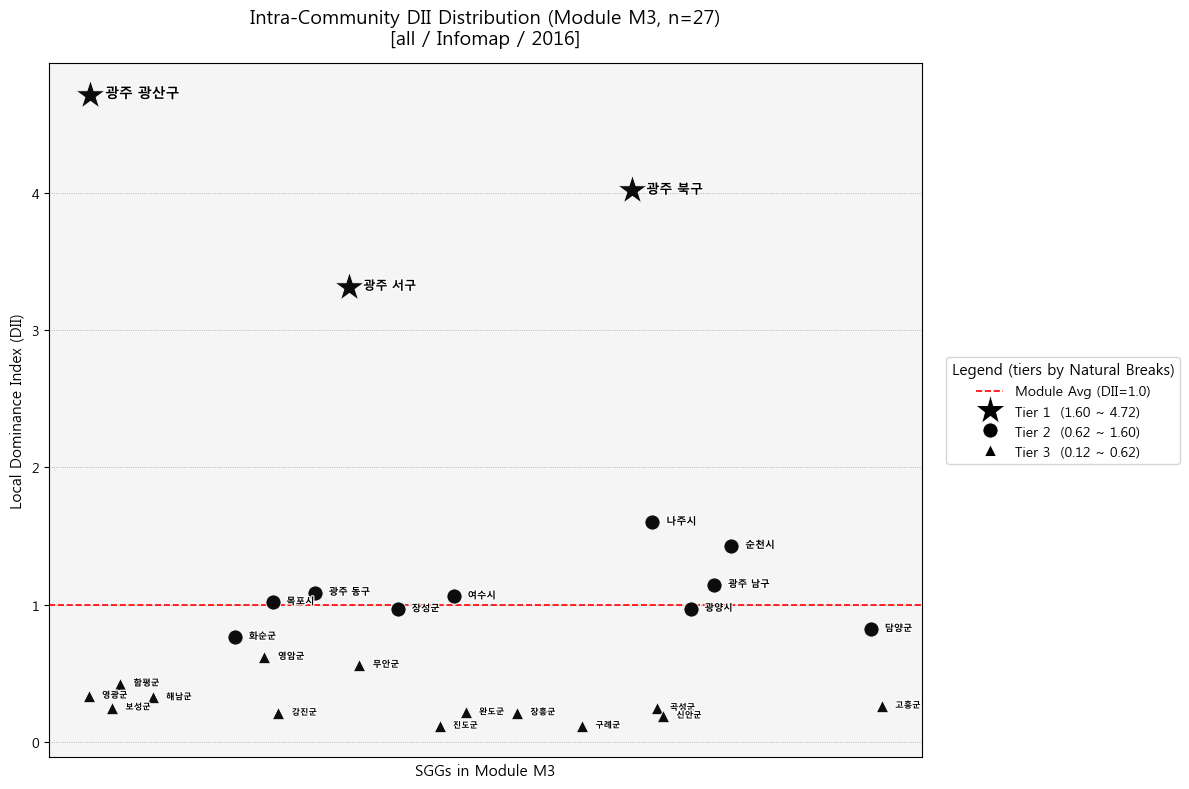

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M3_2016.png


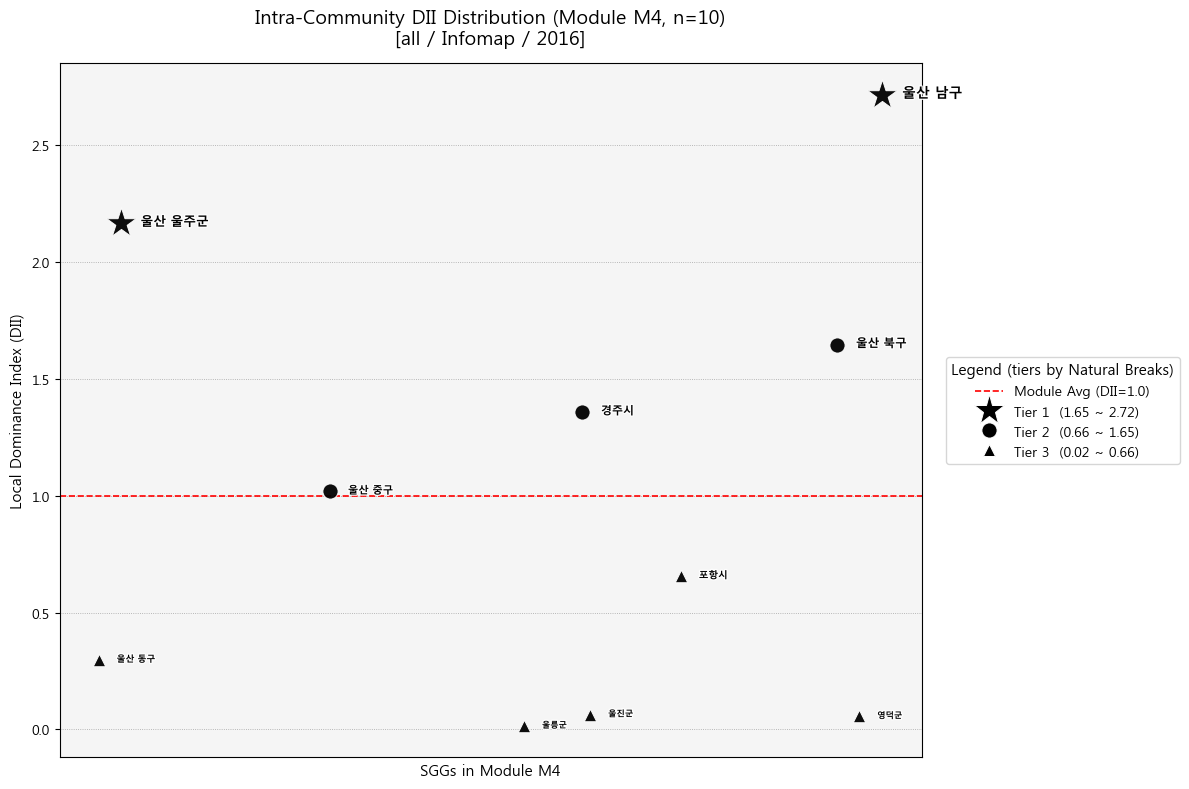

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M4_2016.png


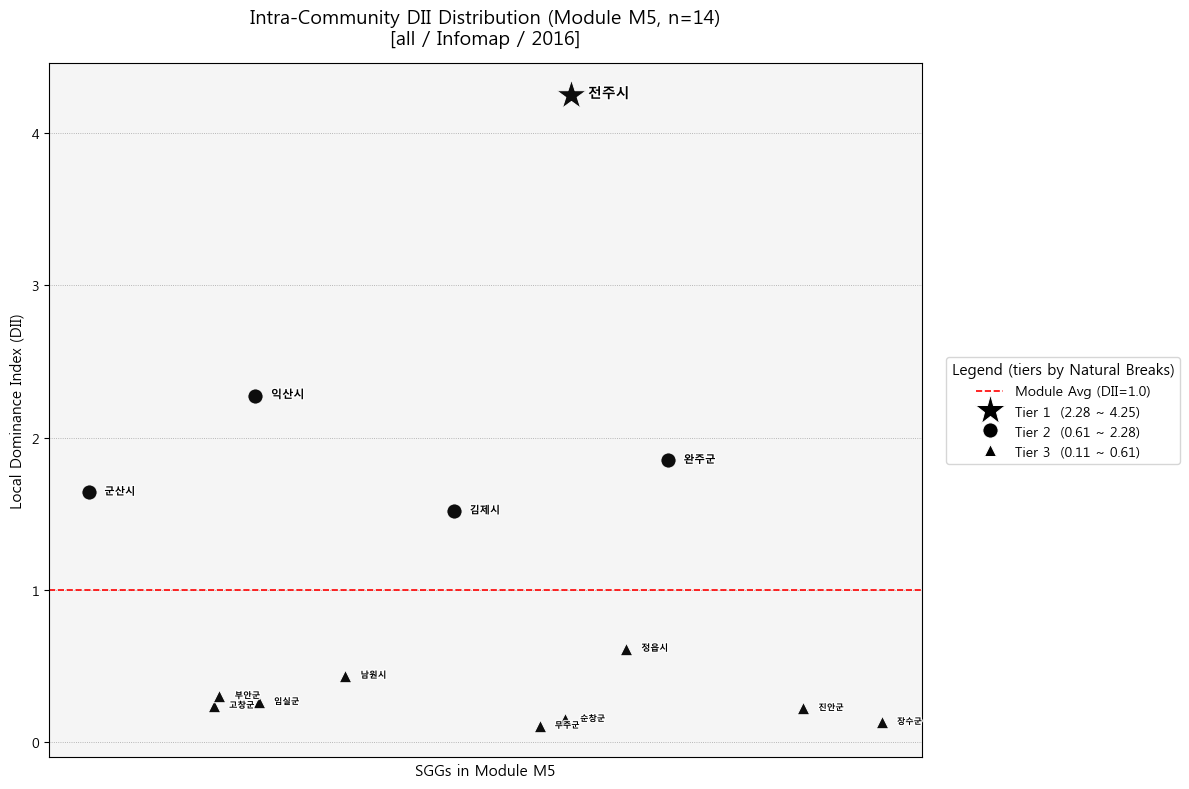

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M5_2016.png


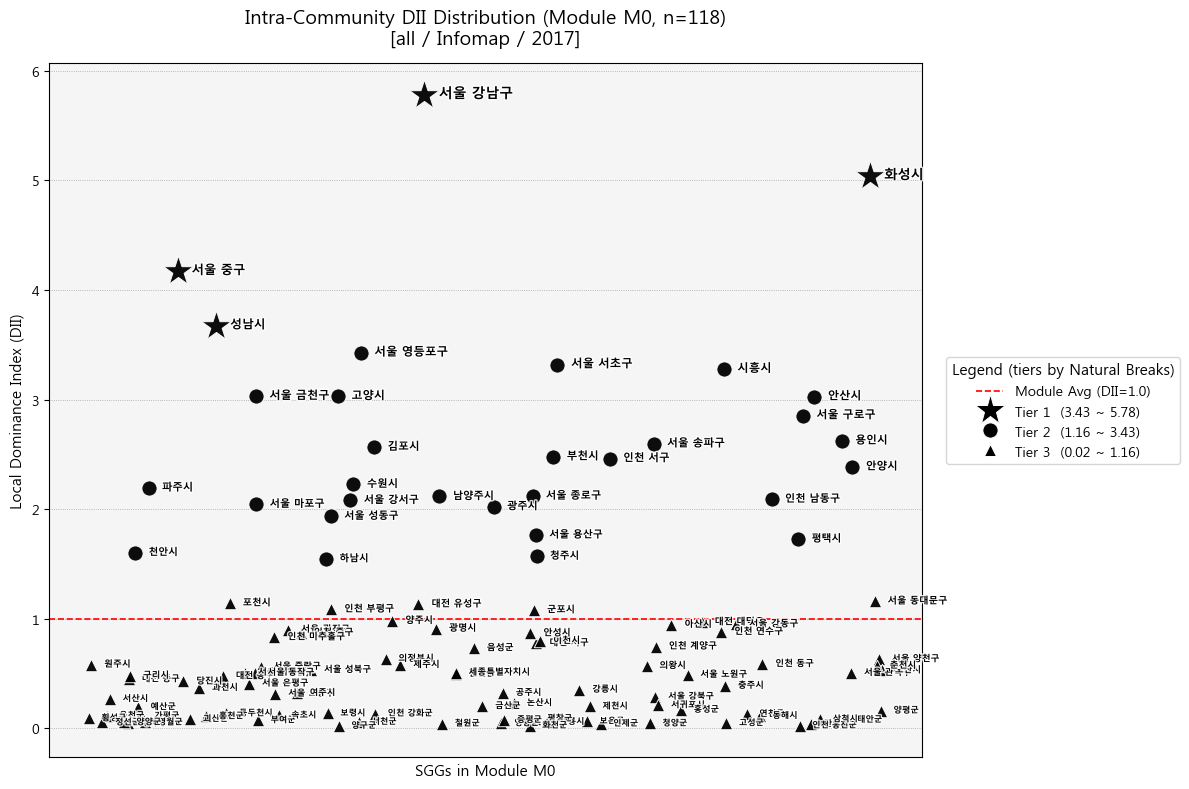

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M0_2017.png


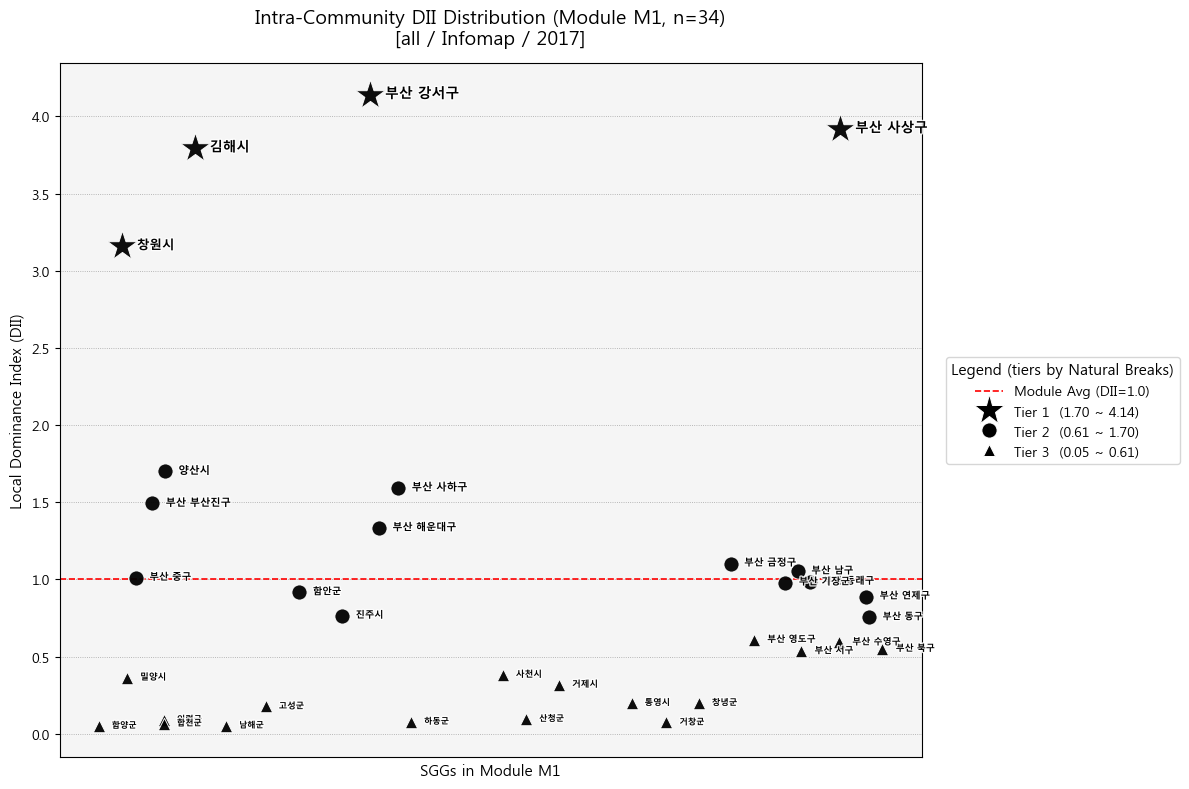

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M1_2017.png


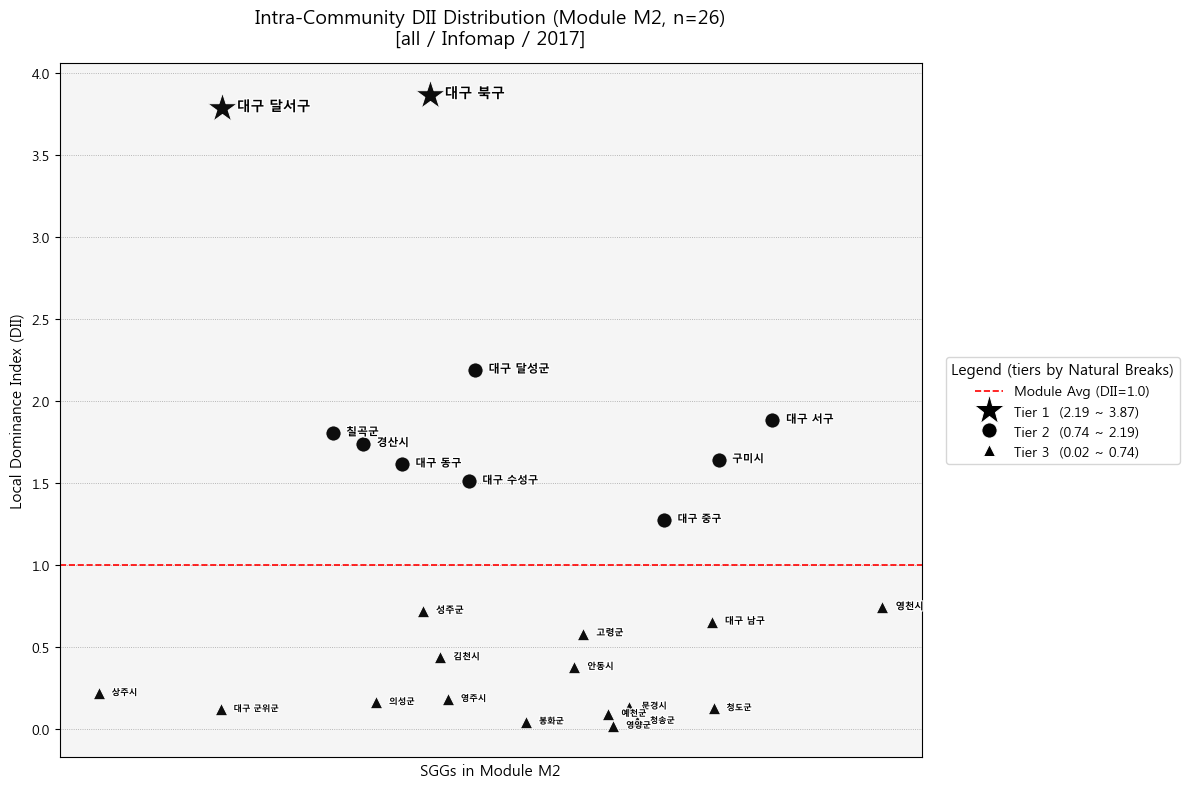

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M2_2017.png


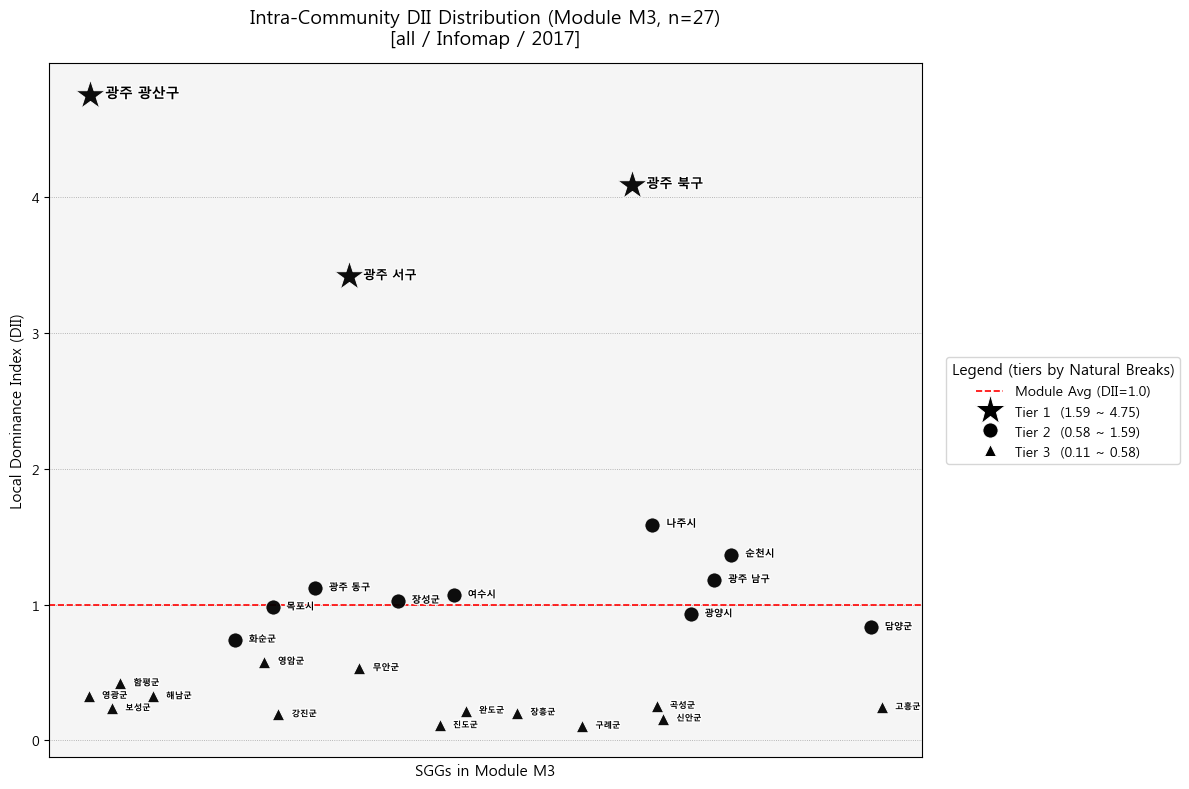

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M3_2017.png


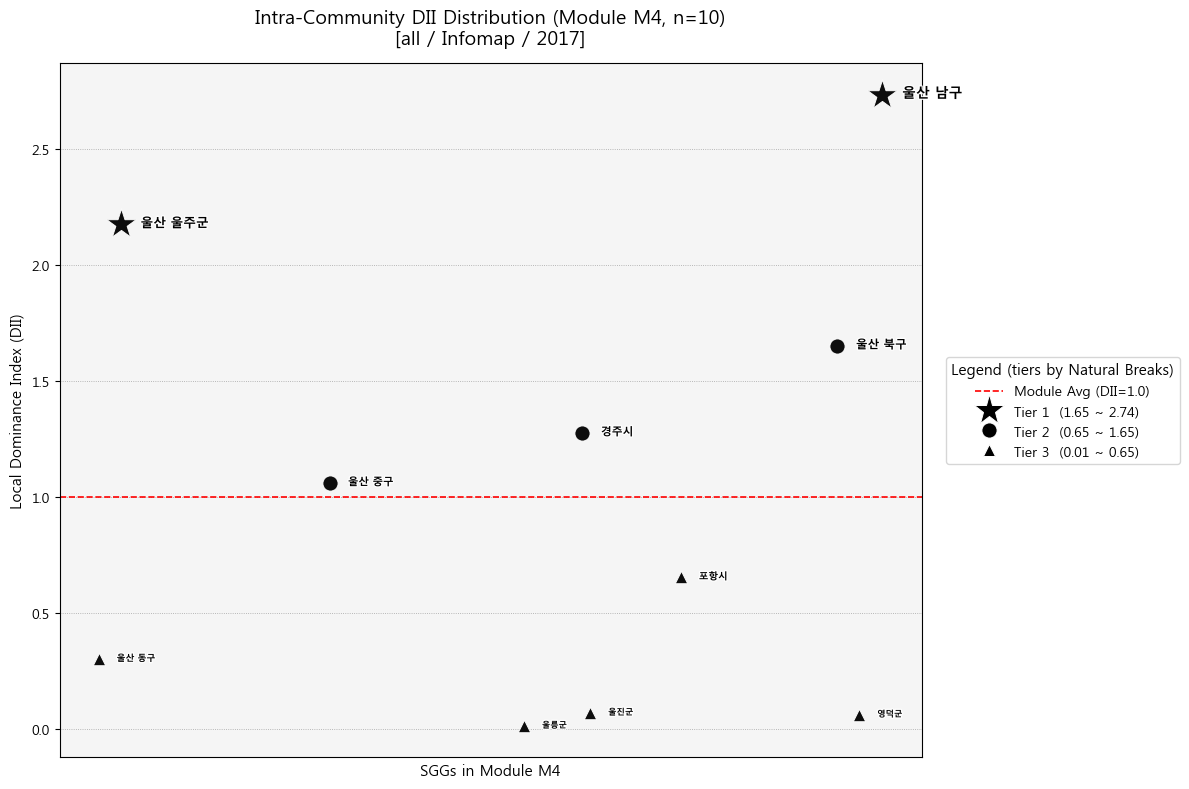

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M4_2017.png


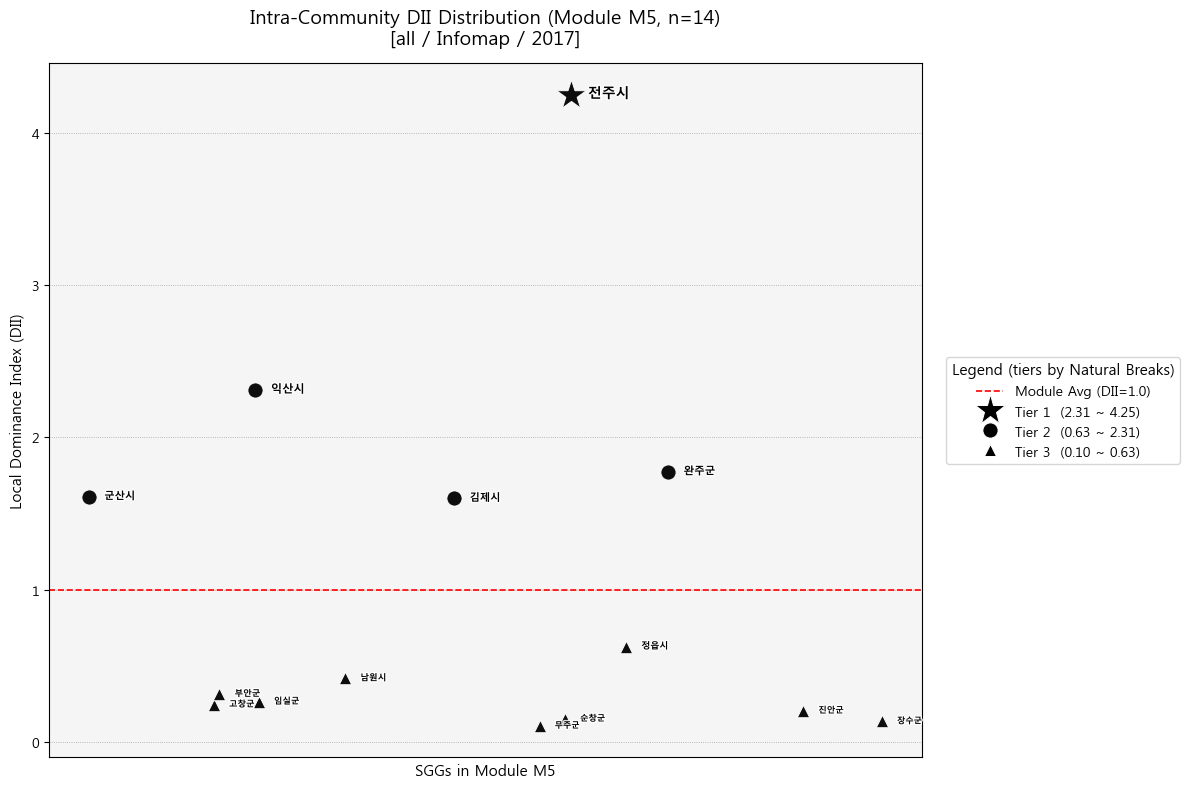

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M5_2017.png


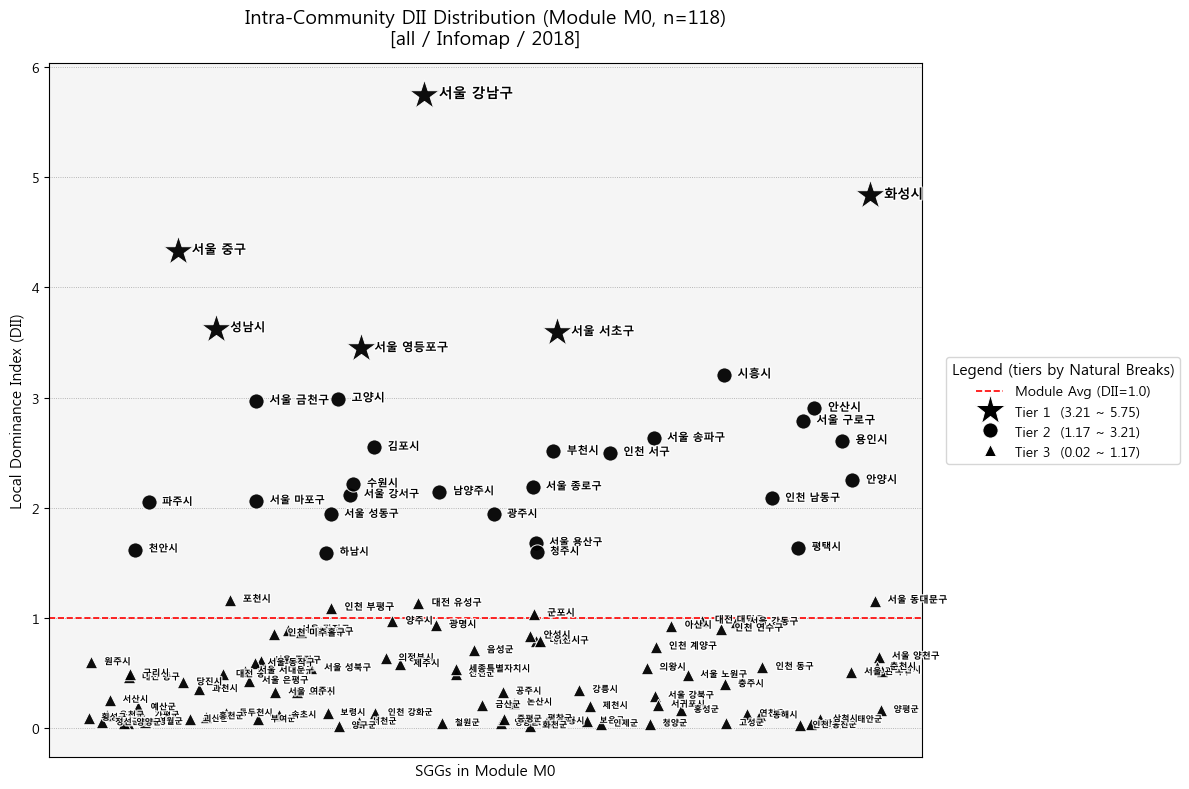

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M0_2018.png


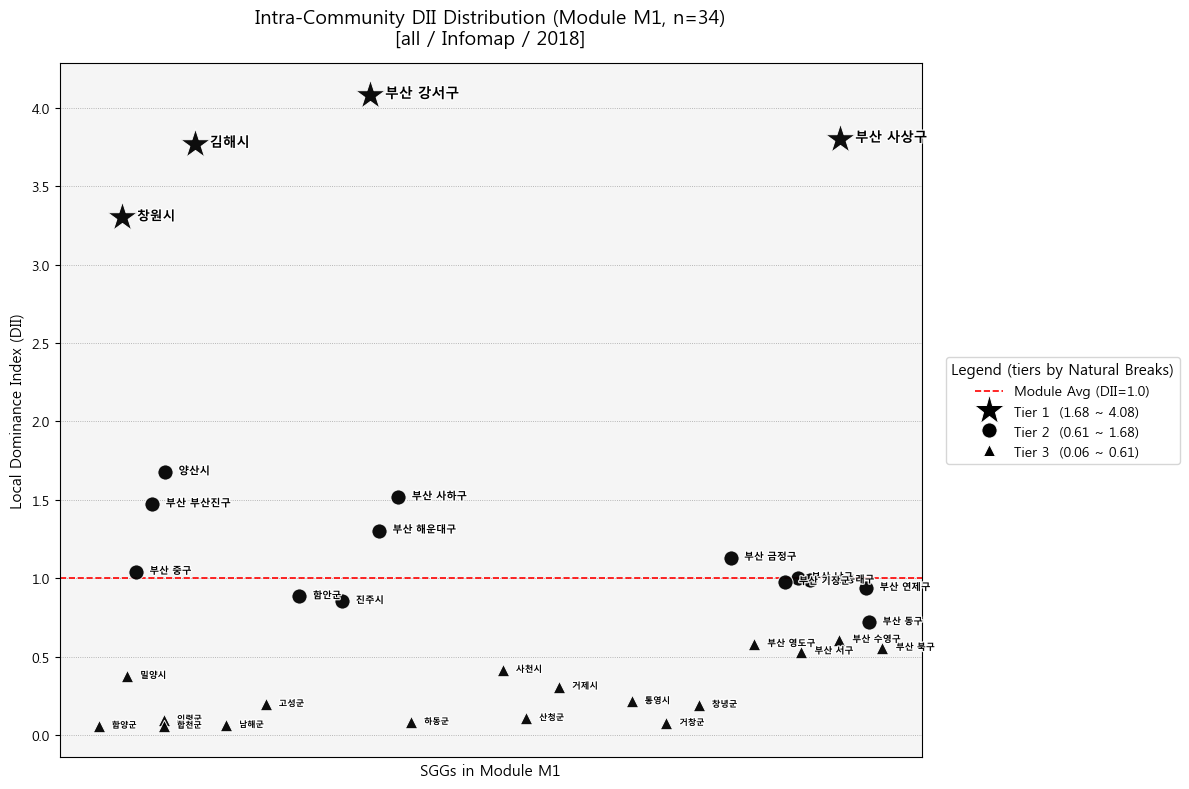

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M1_2018.png


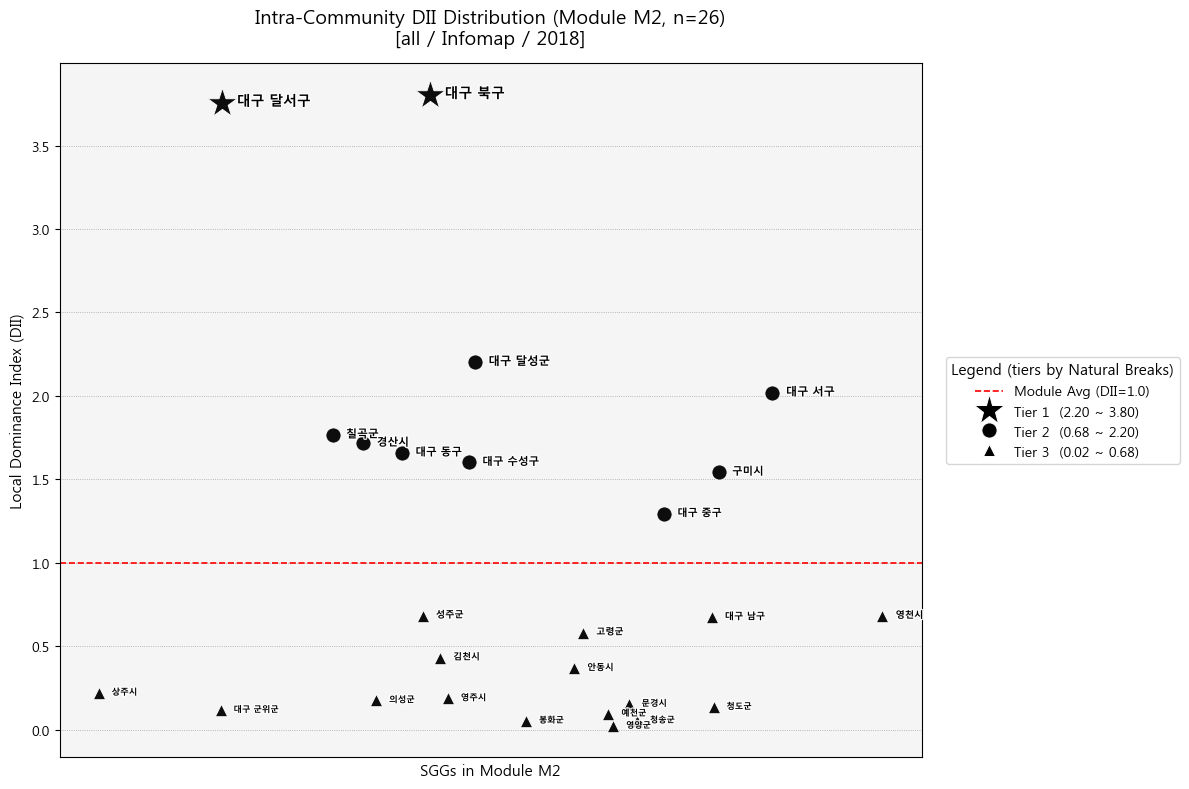

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M2_2018.png


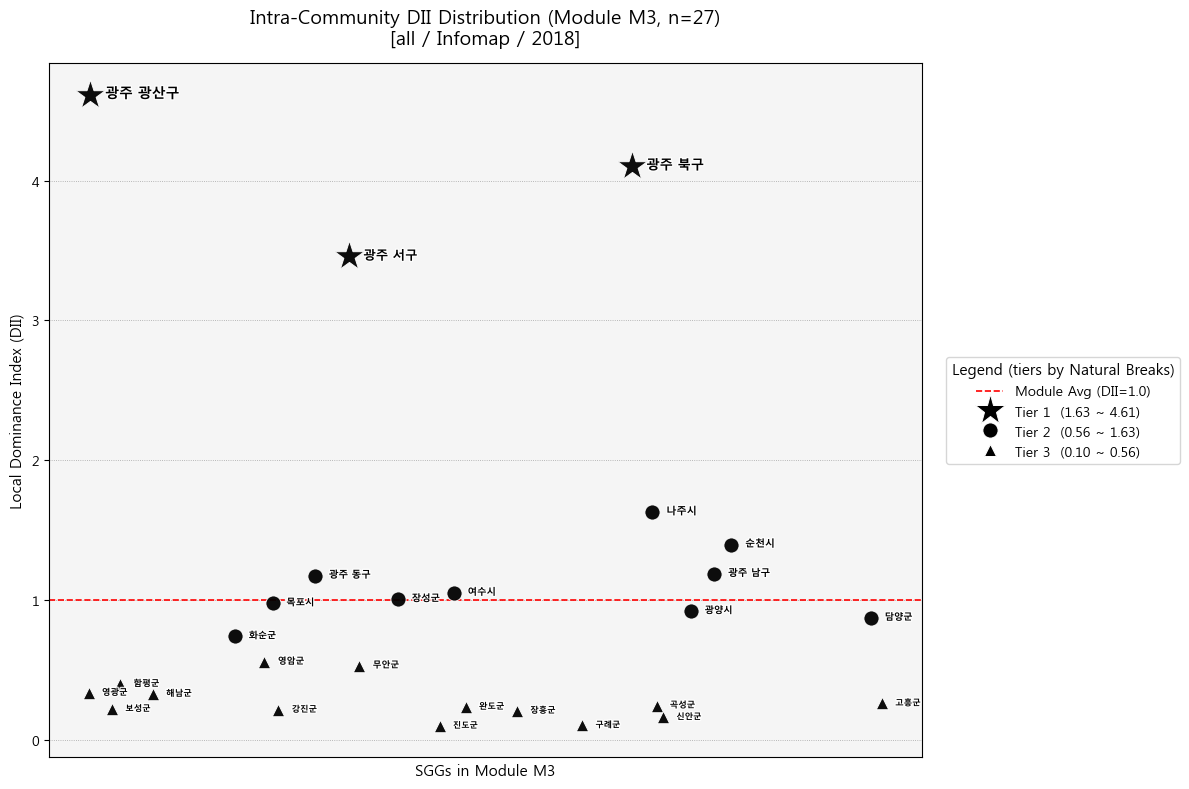

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M3_2018.png


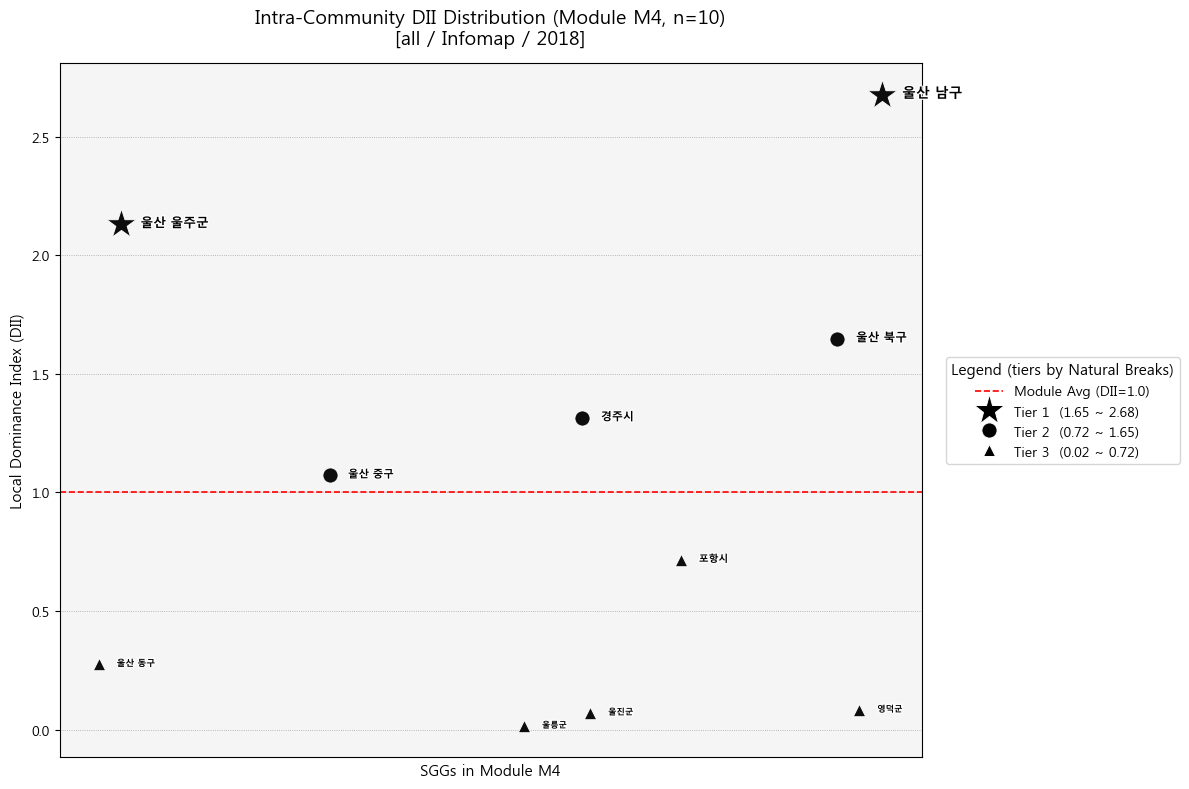

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M4_2018.png


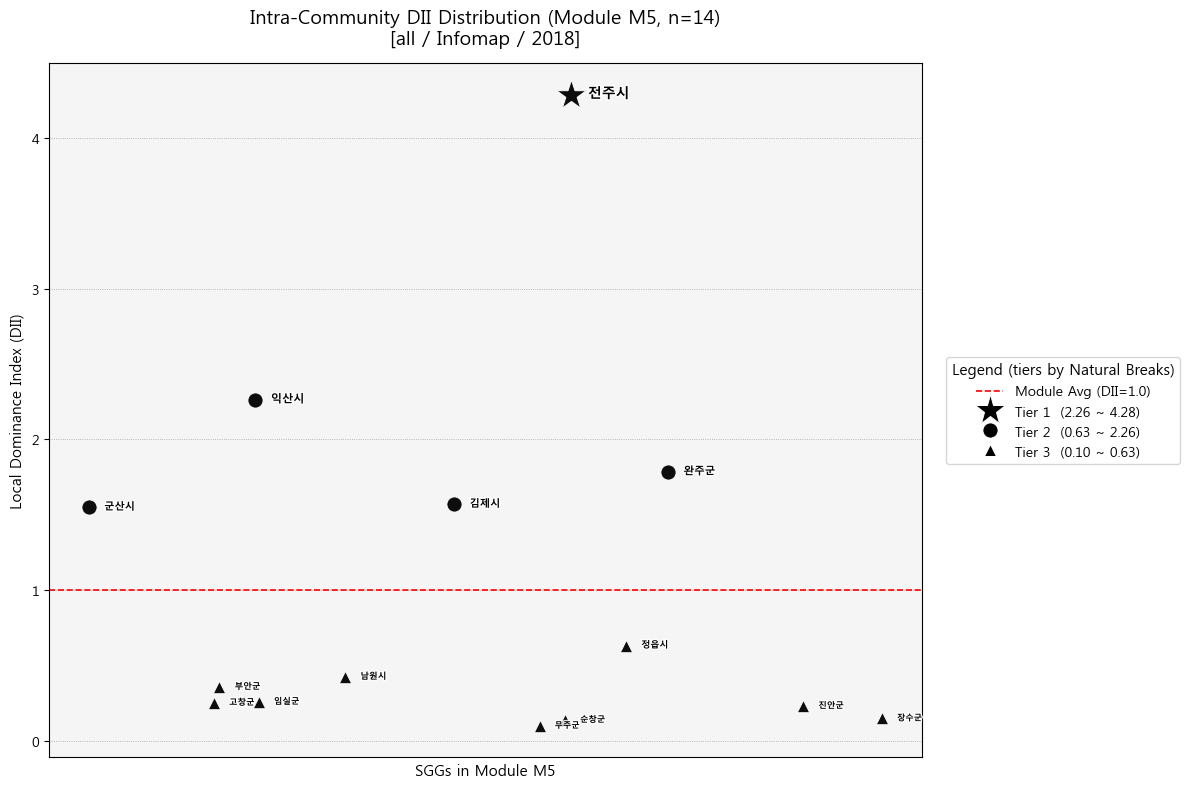

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M5_2018.png


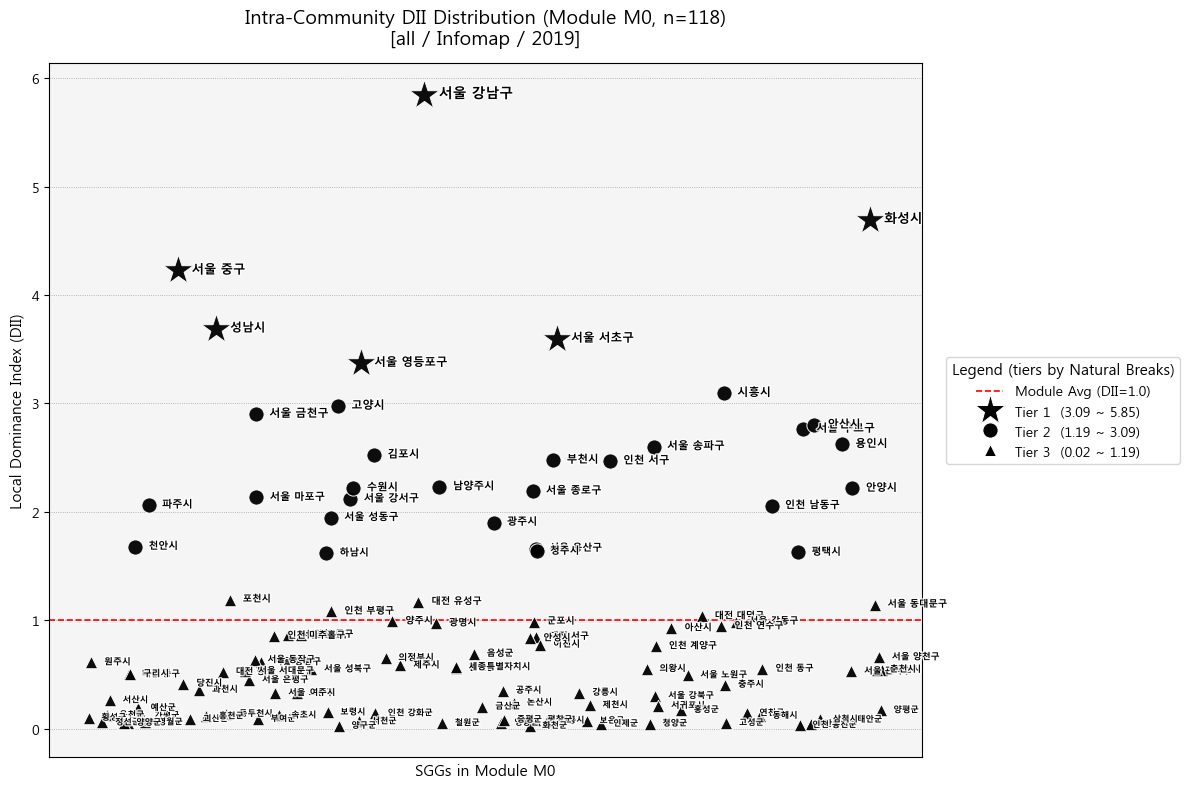

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M0_2019.png


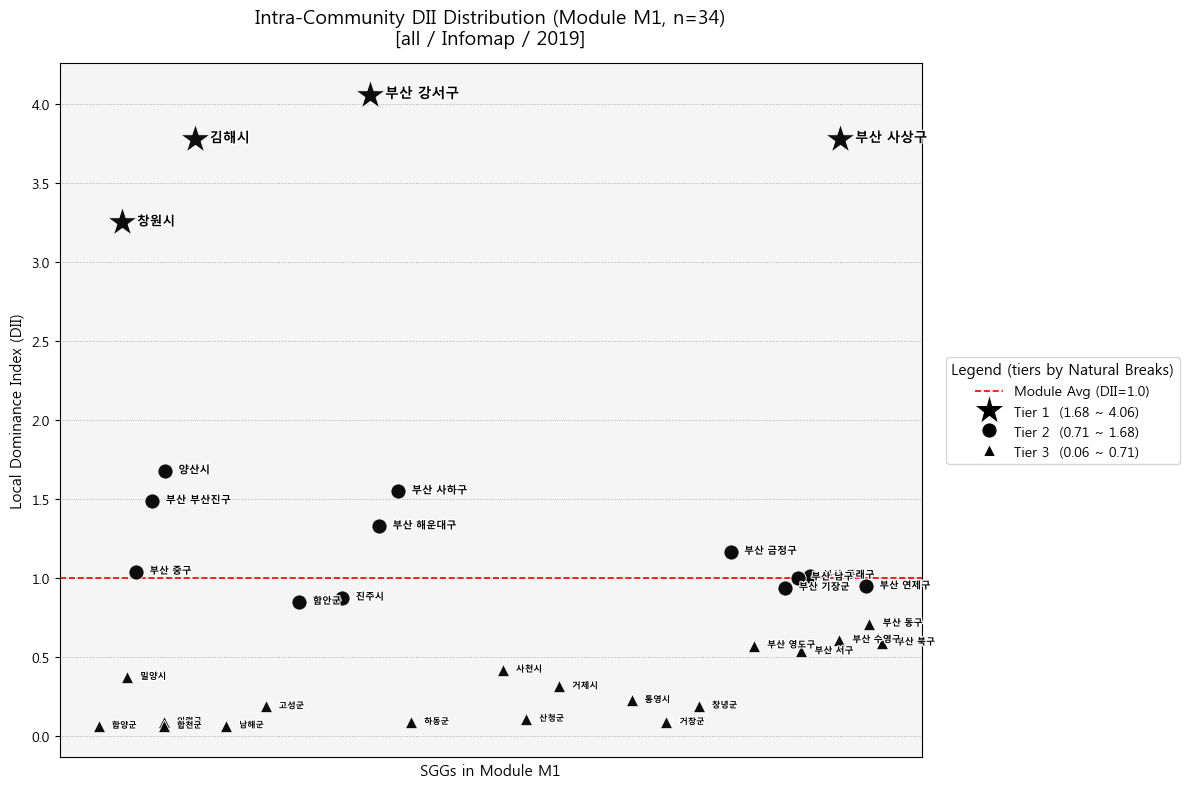

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M1_2019.png


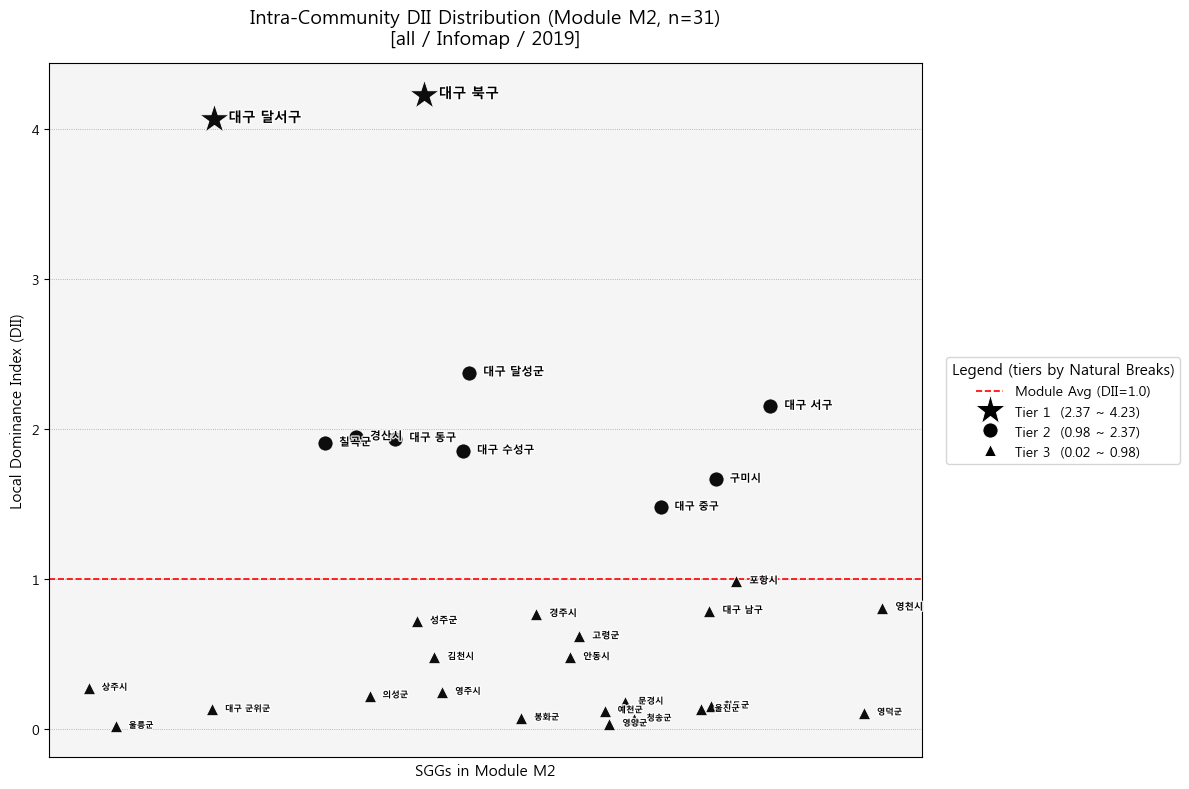

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M2_2019.png


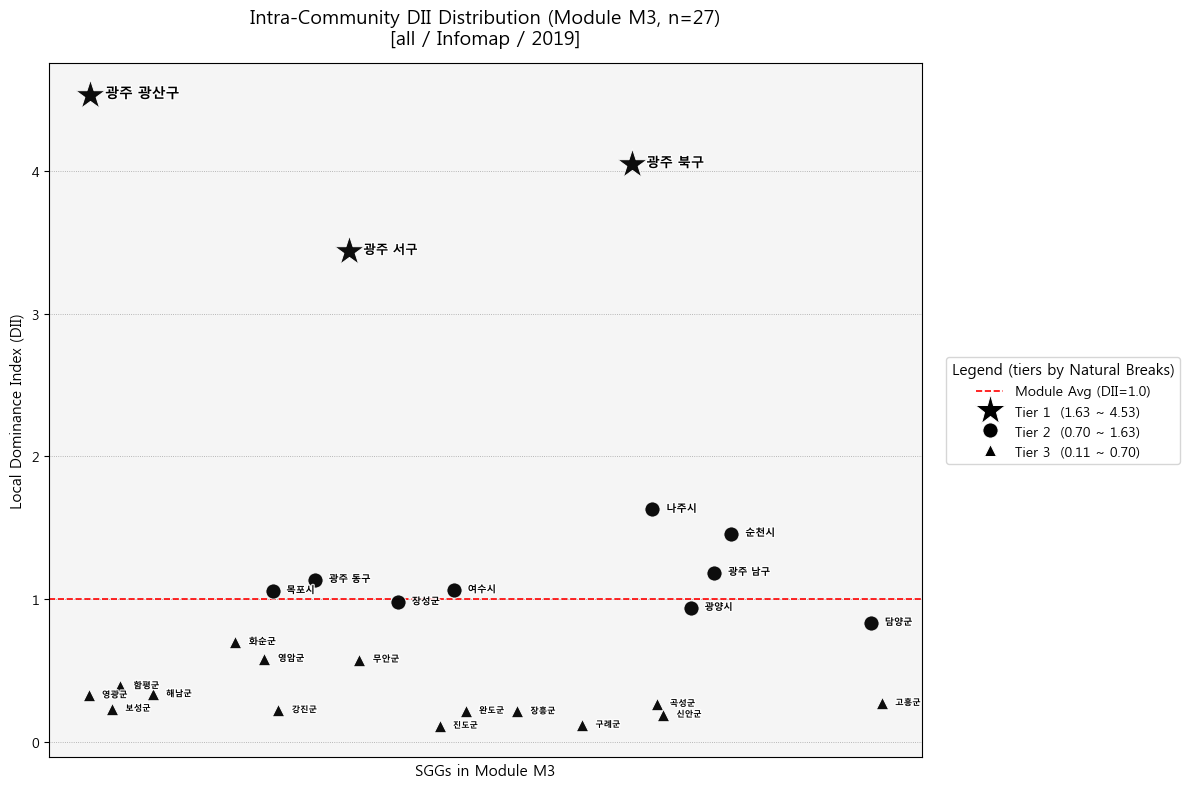

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M3_2019.png


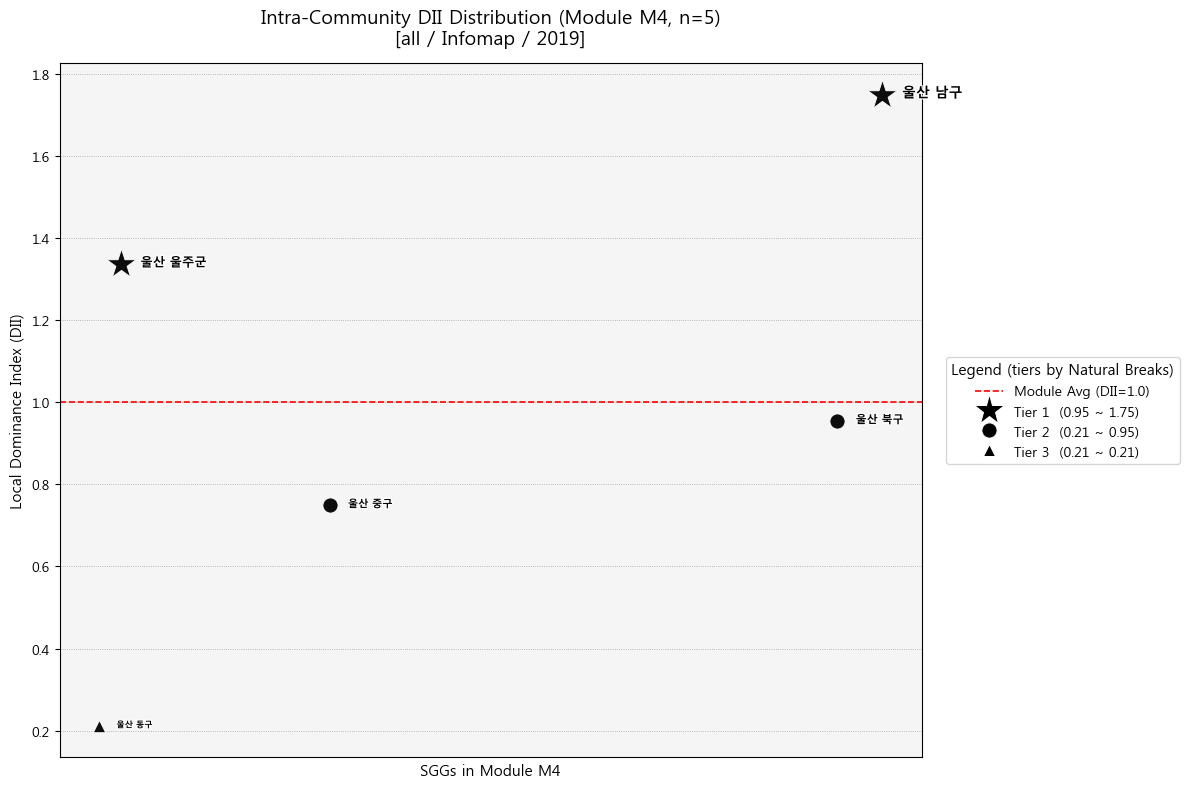

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M4_2019.png


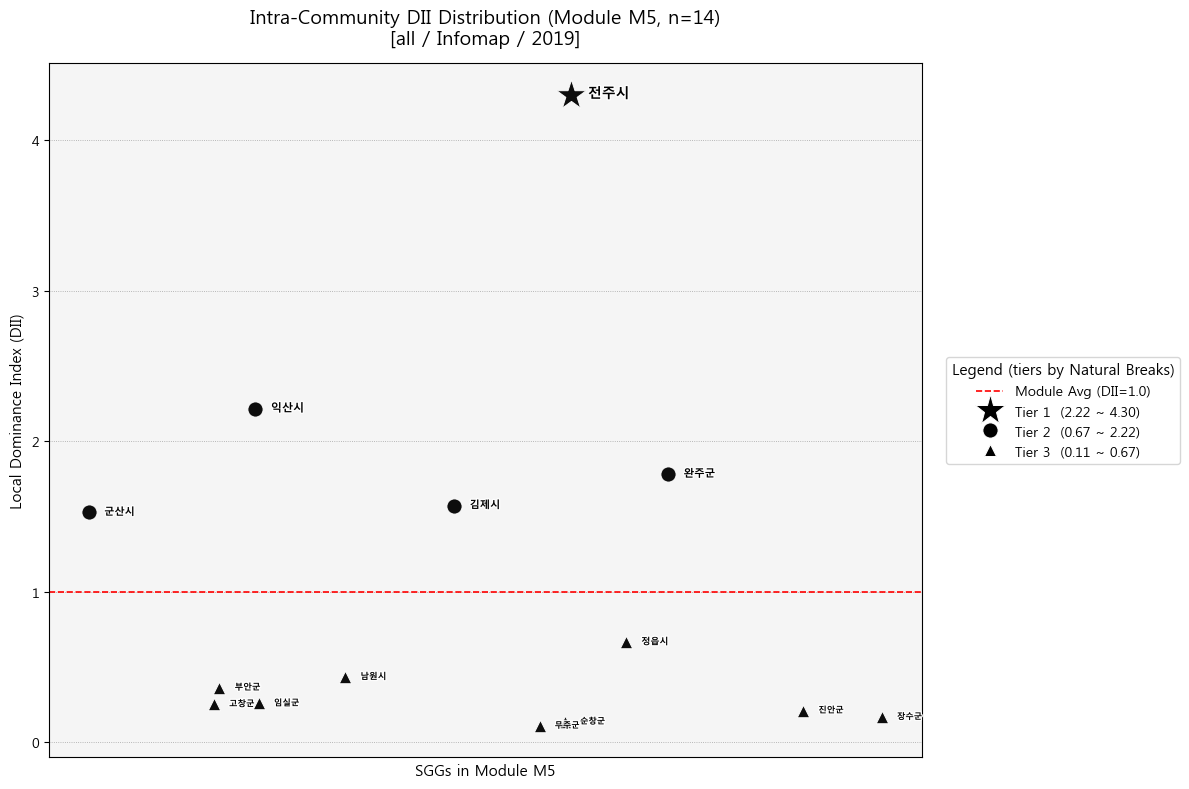

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M5_2019.png


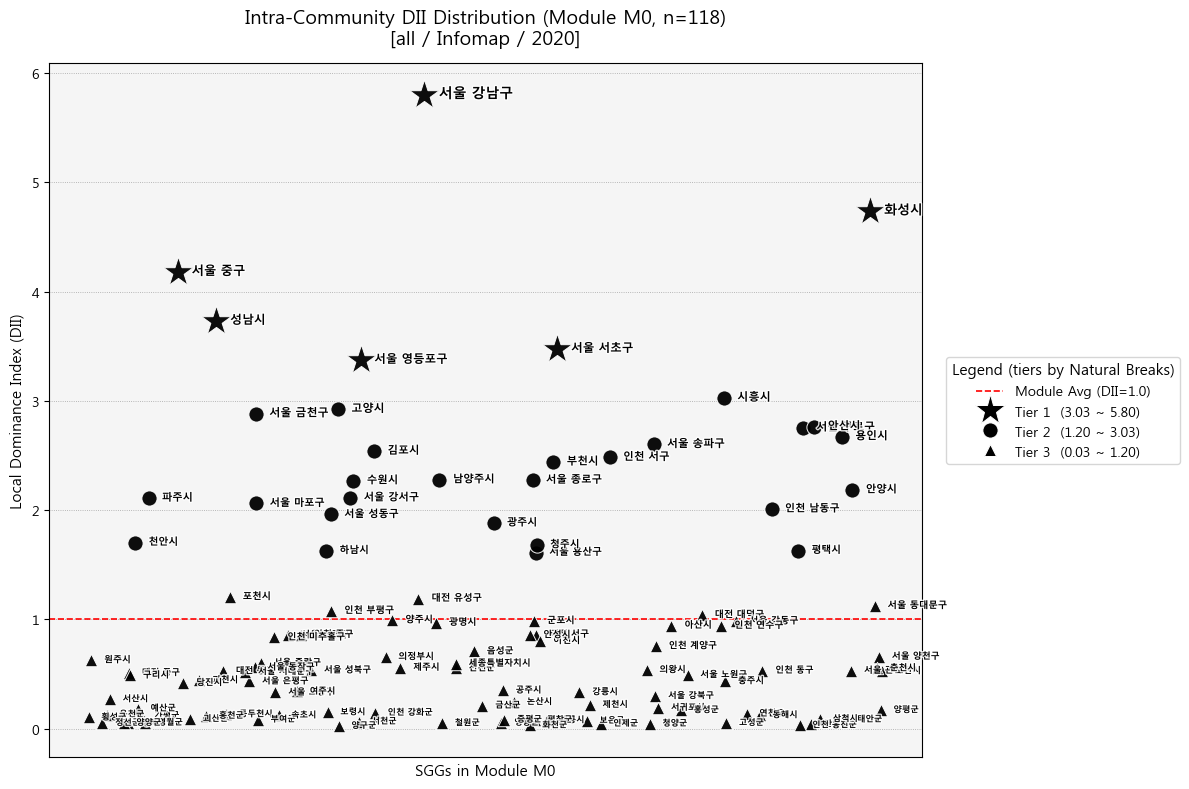

  [OK] Ready SGG DII plot: outputs/figures/communities/inter_hierarchy/all/거래관계/Infomap/dii_sgg_dist_M0_2020.png


KeyboardInterrupt: 

In [ ]:
# file: step4_plot_intra_community_dii_tiers.py
import os, re, gc
import numpy as np
import pandas as pd
import geopandas as gpd
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ========= Paths / Parameters =========
OUT_DIR = "outputs/figures/communities/inter_hierarchy"   # Output directory
COMM_BASE_DIR = "outputs/gpkg/communities"                # …/{key}/{weight}_SGG_map_zone_community.gpkg
SGG_MAP_PATH  = "outputs/map/SGG_map.gpkg"                # Modify to match project path if needed
COMMUNITY_METHODS = ['Infomap', "Leiden", "Louvain"]
WEIGHTS = ["거래관계"]

# ---- Classification / Display ----
N_TIERS = 3                 # Maximum 3 tiers (automatically reduced if data is small)
JITTER_STRENGTH = 0.25      # X-axis jitter strength
FONT_SIZE_MIN = 6.0
FONT_SIZE_MAX = 10.0

# [MODIFIED] Point size by tier (s in scatter is based on area pt^2)
POINT_SIZE_BASE = 80
TIER_SIZE_MAP = {  # Tier 1 should be the largest
    1: 500,        # ★
    2: 120,        # ●
    3: 80          # ▲
}
POINT_FACE = "black"     # All points use same color (tier is distinguished by marker shape only)
POINT_EDGE = "white"
POINT_EW   = 0.7

# Distinguish tiers by marker shape
MARKER_MAP = {
    1: '*',  # Tier 1 (top)
    2: 'o',  # Tier 2
    3: '^'   # Tier 3 (bottom)
}

def safe_name(s: str) -> str:
    return re.sub(r"[^0-9A-Za-z가-힣_.\-]+", "_", str(s))

os.makedirs(OUT_DIR, exist_ok=True)

# ===== Fallback SGG names (from map) =====
SGG_names_fallback = {}
if os.path.exists(SGG_MAP_PATH):
    try:
        SGG = gpd.read_file(SGG_MAP_PATH)
        if "SIG_KOR_NM" not in SGG.columns and "SIG_ENG_NM" in SGG.columns:
            SGG["SIG_KOR_NM"] = SGG["SIG_ENG_NM"]
        SGG["SIG_CD"] = SGG["SIG_CD"].astype(str)
        SGG_names_fallback = SGG.set_index("SIG_CD")["SIG_KOR_NM"].to_dict()
    except Exception as e:
        print(f"[WARN] SGG map load failed: {e}")

# [REPLACE] stable_jitter function
def stable_jitter(key, method, cid, sgg_code, strength=JITTER_STRENGTH, seed=GLOBAL_SEED):
    """
    Always return the same jitter for the same (key, method, cid, sgg_code),
    independent of year. Changing seed will change the whole pattern.
    """
    s = f"{seed}|{key}|{method}|{int(cid)}|{sgg_code}"
    # blake2b hash → 64-bit integer → [0,1) float
    h = int.from_bytes(hashlib.blake2b(s.encode("utf-8"), digest_size=8).digest(), "big")
    u = (h % (1 << 53)) / float(1 << 53)  # uniform [0,1)
    return 1.0 + (u * 2.0 - 1.0) * strength  # 1.0 ± strength


# ===== Main Loop =====
# Assumption: nw_dict is already loaded into memory
for key, ed_original in nw_dict.items():
    for weight in WEIGHTS:
        gpkg_path = os.path.join(COMM_BASE_DIR, key, f"{weight}_SGG_map_zone_community.gpkg")
        if not os.path.exists(gpkg_path):
            print(f"[SKIP] {gpkg_path} not found")
            continue

        g_comm = gpd.read_file(gpkg_path)
        if "SIGUNGU_CD" not in g_comm.columns:
            print(f"[SKIP] {key}/{weight}: 'SIGUNGU_CD' not found")
            continue
        g_comm["SIGUNGU_CD"] = g_comm["SIGUNGU_CD"].astype(str)

        # ---- Prefer names from community GPKG ----
        name_col_candidates = [c for c in ["SIGUNGU_NM", "SIG_KOR_NM", "SIGUNGU_NAME", "SIG_NM"]
                               if c in g_comm.columns]
        name_col = name_col_candidates[0] if name_col_candidates else None
        if name_col:
            name_map = dict(zip(g_comm["SIGUNGU_CD"].astype(str), g_comm[name_col].astype(str)))
        else:
            name_map = SGG_names_fallback  # fallback

        def get_name(code: str) -> str:
            code = str(code)
            return name_map.get(code, SGG_names_fallback.get(code, code))

        for method in COMMUNITY_METHODS:
            print(f"--- Processing [{key} / {weight} / {method}] ---")

            years = sorted({
                int(c.split("_")[-1]) for c in g_comm.columns
                if c.startswith(f"{method}_canon_") and c.split("_")[-1].isdigit()
            })
            if not years:
                print("  [SKIP] No canonical years found.")
                continue

            # Standardize original edge table
            rename_map = {
                '1_기준연도': 'year',
                '8_시군구코드_seller': 'source',
                '14_시군구코드_buyer': 'target',
                weight: 'weight'
            }
            ed.rename(columns={k: v for k, v in rename_map.items() if k in ed.columns}, inplace=True)
            required_cols = ['year', 'source', 'target', 'weight']
            if not all(c in ed.columns for c in required_cols):
                print(f"  [SKIP] Missing required columns in edge data.")
                continue

            ed_use = ed[required_cols].dropna().copy()
            ed_use[['source', 'target']] = ed_use[['source', 'target']].astype(str)
            ed_use['year'] = pd.to_numeric(ed_use['year'], errors='coerce')
            ed_use['weight'] = pd.to_numeric(ed_use['weight'], errors='coerce').fillna(0)

            # ===== Process year by year =====
            for year in years:
                col_canon = f"{method}_canon_{year}"
                if col_canon not in g_comm.columns:
                    continue

                # Community (module) label map for this year
                s_year = g_comm[["SIGUNGU_CD", col_canon]].dropna()
                s_year[col_canon] = s_year[col_canon].astype(int)
                lab_map = s_year.set_index("SIGUNGU_CD")[col_canon].to_dict()

                # Edge data of that year
                ede = ed_use[ed_use["year"] == year].copy()
                if ede.empty:
                    continue

                # Map modules
                ede["m_s"] = ede["source"].map(lab_map)
                ede["m_t"] = ede["target"].map(lab_map)
                ede = ede.dropna(subset=["m_s", "m_t"])
                ede[["m_s", "m_t"]] = ede[["m_s", "m_t"]].astype(int)

                # === Only keep intra-community (within-module) links ===
                ede_in = ede[ede["m_s"] == ede["m_t"]].copy()
                if ede_in.empty:
                    continue

                # Compute SGG-level DII inside each module & visualize
                for cid, F_all in ede_in.groupby('m_s'):
                    # Members of this module
                    members = s_year[s_year[col_canon] == cid]["SIGUNGU_CD"].astype(str).tolist()
                    if len(members) < 2:
                        continue

                    # --- 1) Sum of IO by SGG
                    io_sum = {}
                    F_use = F_all[F_all['source'] != F_all['target']]  # exclude self-loops
                    for _, r in F_use.iterrows():
                        s, t, wv = r['source'], r['target'], r['weight']
                        io_sum[s] = io_sum.get(s, 0.0) + wv
                        io_sum[t] = io_sum.get(t, 0.0) + wv

                    # DII relative to module average
                    if not io_sum:
                        continue
                    mean_io = np.mean(list(io_sum.values()))
                    if mean_io <= 0:
                        continue

                    dii_records = [{'sgg_code': sgg, 'dii': io_sum.get(sgg, 0.0) / mean_io} for sgg in members]
                    sgg_dii_df = pd.DataFrame(dii_records)
                    if sgg_dii_df.empty:
                        continue

                    # --- 2) Tier classification (Natural Breaks -> max 3 tiers)
                    uniq = sgg_dii_df['dii'].nunique()
                    k = min(N_TIERS, uniq)
                    if k > 1:
                        classifier = mapclassify.NaturalBreaks(sgg_dii_df['dii'], k=k)
                        # yb: 0(low) ~ k-1(high), → Tier 1(high) ~ Tier k(low), reversed
                        sgg_dii_df['tier'] = (k - classifier.yb).astype(int)
                        bins = classifier.bins.copy()
                    else:
                        classifier = None
                        sgg_dii_df['tier'] = 1
                        bins = None

                    # --- 3) Font size scale (based on DII)
                    dii_min, dii_max = sgg_dii_df['dii'].min(), sgg_dii_df['dii'].max()
                    span = dii_max - dii_min
                    if span > 0:
                        sgg_dii_df['norm'] = (sgg_dii_df['dii'] - dii_min) / span
                    else:
                        sgg_dii_df['norm'] = 0.5
                    sgg_dii_df['font_size'] = FONT_SIZE_MIN + sgg_dii_df['norm'] * (FONT_SIZE_MAX - FONT_SIZE_MIN)

                    # --- 4) X-axis jitter (year-invariant, fixed by community/method/SGG)
                    sgg_dii_df['x'] = sgg_dii_df['sgg_code'].apply(
                        lambda code: stable_jitter(key, method, int(cid), str(code), strength=JITTER_STRENGTH)
                    )

                    # --- 5) Plot
                    outdir = os.path.join(OUT_DIR, key, method)
                    os.makedirs(outdir, exist_ok=True)
                    outpath = os.path.join(outdir, f"dii_sgg_dist_M{safe_name(cid)}_{year}.png")

                    fig, ax = plt.subplots(figsize=(14, 8), dpi=100)

                    # [MODIFIED] Draw from bottom → top so ★ appears on top
                    present_tiers = sorted(sgg_dii_df['tier'].unique(), reverse=True)
                    for tier in present_tiers:
                        mk = MARKER_MAP.get(tier, 'o')
                        sub = sgg_dii_df[sgg_dii_df['tier'] == tier]
                        ax.scatter(
                            x=sub['x'], y=sub['dii'],
                            s=TIER_SIZE_MAP.get(tier, POINT_SIZE_BASE),  # size by tier
                            marker=mk,
                            c=POINT_FACE, edgecolors=POINT_EDGE, linewidth=POINT_EW,
                            alpha=0.95, zorder=10
                        )

                    # Labels: name + font size scaled by DII
                    for _, row in sgg_dii_df.iterrows():
                        name = get_name(row['sgg_code'])
                        txt = ax.text(
                            row['x']+0.006, row['dii']+0.002, f" {name}",
                            fontsize=row['font_size'], color='black',
                            ha='left', va='center', weight='bold', zorder=11
                        )
                        txt.set_path_effects([
                            path_effects.Stroke(linewidth=2.0, foreground='white', alpha=0.85),
                            path_effects.Normal()
                        ])

                    # Reference line & axis formatting
                    ax.axhline(1.0, color='red', linestyle='--', linewidth=1.2, label='Module Avg (DII=1.0)')
                    ax.set_title(
                        f"Intra-Community DII Distribution (Module M{cid}, n={len(members)})\n[{key} / {method} / {year}]",
                        fontsize=14, pad=14
                    )
                    ax.set_ylabel("Local Dominance Index (DII)", fontsize=11)
                    ax.set_xlabel(f"SGGs in Module M{cid}", fontsize=11)
                    ax.set_xticks([])
                    ax.grid(axis='y', linestyle=':', linewidth=0.6, color='gray', alpha=0.7)

                    # === Legend: only tiers ===
                    leg_handles, leg_labels = [], []
                    h_line = Line2D([0], [0], color='red', linestyle='--', linewidth=1.2, label='Module Avg (DII=1.0)')
                    leg_handles.append(h_line); leg_labels.append(h_line.get_label())

                    if classifier and k > 1:
                        # bins: upper bounds (ascending). Reverse so Tier 1 is top bin
                        bounds = []
                        lo = sgg_dii_df['dii'].min()
                        for i in range(k):
                            hi = bins[i]
                            bounds.append((lo, hi))
                            lo = hi
                        bounds = list(reversed(bounds))
                        for t_idx, t in enumerate(range(1, k+1), start=0):
                            mk = MARKER_MAP.get(t, 'o')
                            lo_b, hi_b = bounds[t_idx]
                            tier_text = f"Tier {t}  ({lo_b:.2f} ~ {hi_b:.2f})"
                            # [MODIFIED] Match marker size in legend to scatter (roughly)
                            ms = max(8, (TIER_SIZE_MAP.get(t, POINT_SIZE_BASE)) ** 0.5)
                            leg_handles.append(Line2D([], [], marker=mk, linestyle='None',
                                                      markersize=ms,
                                                      markerfacecolor=POINT_FACE,
                                                      markeredgecolor=POINT_EDGE, markeredgewidth=POINT_EW,
                                                      label=tier_text))
                            leg_labels.append(tier_text)
                    else:
                        mk = MARKER_MAP.get(1, 'o')
                        tier_text = "Tier 1 (single-bin)"
                        ms = max(8, (TIER_SIZE_MAP.get(1, POINT_SIZE_BASE)) ** 0.5)
                        leg_handles.append(Line2D([], [], marker=mk, linestyle='None',
                                                  markersize=ms,
                                                  markerfacecolor=POINT_FACE,
                                                  markeredgecolor=POINT_EDGE, markeredgewidth=POINT_EW,
                                                  label=tier_text))
                        leg_labels.append(tier_text)

                    ax.legend(leg_handles, leg_labels, loc='center left', bbox_to_anchor=(1.02, 0.5),
                              title="Legend (tiers by Natural Breaks)", fontsize=10, title_fontsize=11, frameon=True)
                    ax.patch.set_facecolor("whitesmoke")
                    plt.tight_layout(rect=[0, 0, 0.86, 1])
                    # Uncomment to save
                    plt.savefig(outpath, dpi=110, bbox_inches="tight")
                    #plt.show()
                    plt.close(fig)
                    gc.collect()
                    print(f"  [OK] Ready SGG DII plot: {outpath}")
